In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/exESN/ESN_utils/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import ESN_util.rc_tools as rct

from itertools import chain 
from torchviz import make_dot, make_dot_from_trace

import torch
from torch import nn, Tensor, optim
from torch.nn.parameter import Parameter
import pdb 
from jupyterthemes import jtplot
jtplot.style()

def grad_printer(model: nn.Module) -> nn.Module:
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: print(f'{grad}'))
    return model

In [2]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import optim
DEV = 'cuda:5'
DTYPE = torch.float32 

In [3]:
K = 1
N = 3
L = 1
TRAIN = 1000

In [4]:

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.a = Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = Parameter(torch.rand(1,N))
        self.a_list = []
        self.g_list = []
        
    def forward(self, x, z):
        return (1-self.a)*x + self.a*self.g*torch.tanh(x+z)
    
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        #self.Res = nn.Linear(self.N,self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)
        self.sr_list = []

    def forward(self, hidden, ut):
        self.D.register_hook(lambda x: self.sr_list.append(x.data)) # Gradient
        z = self.Rin(ut)
        ht = torch.matmul(hidden,torch.matmul(self.Q, torch.matmul(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,z)
        output = self.Rout(torch.cat((ht1,ut),1))
        return ht1, output

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        return torch.real(Q), torch.real(D), torch.real(torch.transpose(Q,0,1))
    
    def clearList(self):
        self.a_list = []
        self.g_list = []
        self.sr_list = []


esn = SymESN(K,N,L,1.0,.6)
print(esn)
for n,p in esn.named_parameters():
    print(n)

SymESN(
  (Rin): Linear(in_features=1, out_features=3, bias=False)
  (Lky): Leaky_Tanh()
  (Rout): Linear(in_features=4, out_features=1, bias=False)
)
D
Rin.weight
Lky.a
Lky.g
Rout.weight


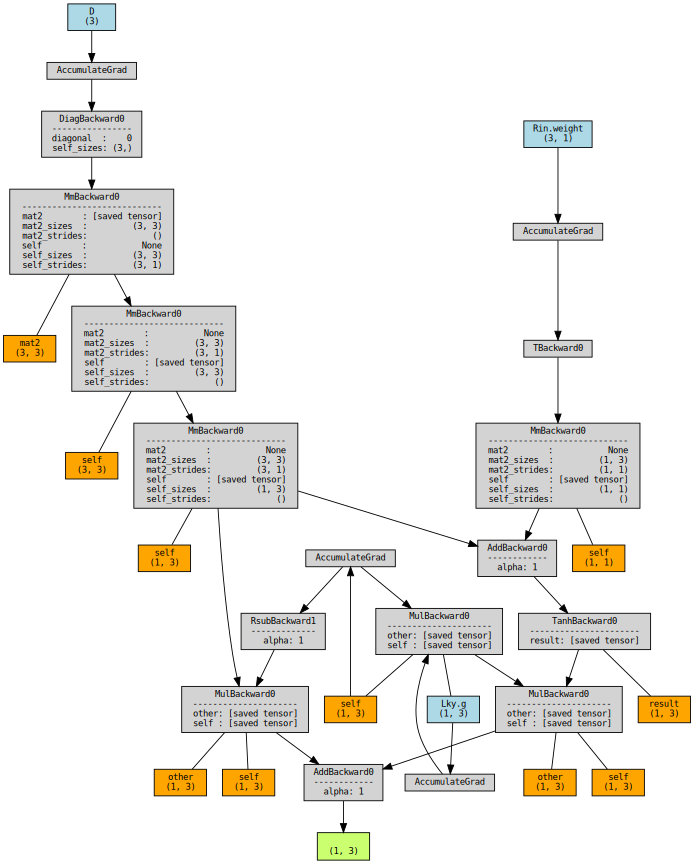

In [5]:
ut = torch.Tensor([[1]])
xt = esn.packState()
xt1, yhat = esn(xt,ut)
make_dot(xt1, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

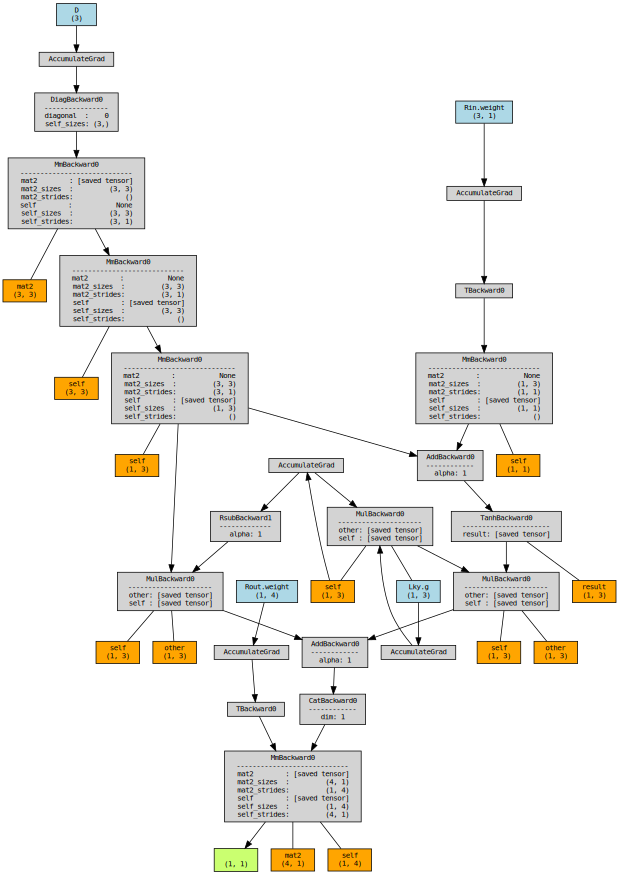

In [6]:
make_dot(yhat, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

In [7]:
FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)
Tl = 1000
muX = np.mean(states[:,0])
signal = states[:Tl,0]-muX

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(),lr=.05)

Eigenvals tensor([0.4787, 0.9596, 0.2343])
Epoch: 0


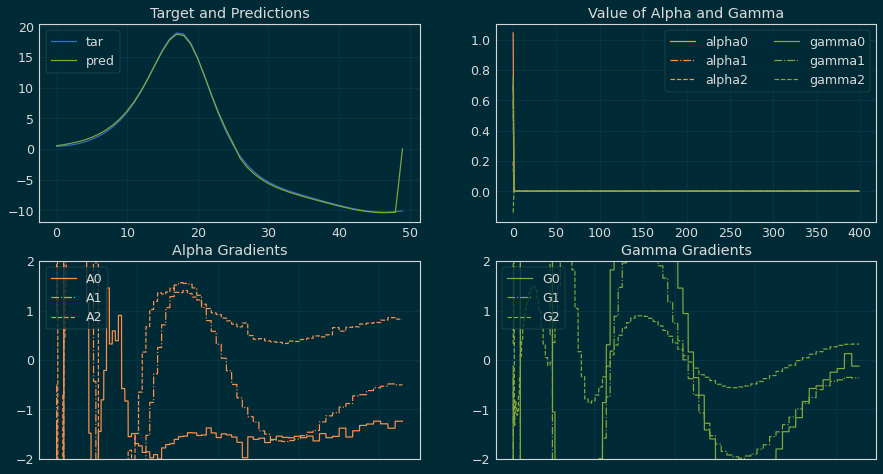

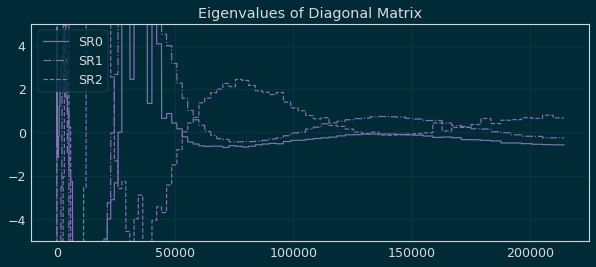

Eigenvals tensor([0.4836, 0.9588, 0.2312])
Eigenvals tensor([0.4889, 0.9582, 0.2280])
Eigenvals tensor([0.4944, 0.9577, 0.2246])
Eigenvals tensor([0.5003, 0.9575, 0.2210])
Eigenvals tensor([0.5065, 0.9574, 0.2173])
Eigenvals tensor([0.5131, 0.9575, 0.2136])
Eigenvals tensor([0.5200, 0.9577, 0.2098])
Eigenvals tensor([0.5272, 0.9579, 0.2061])
Eigenvals tensor([0.5348, 0.9583, 0.2023])
Eigenvals tensor([0.5427, 0.9586, 0.1985])
Epoch: 10


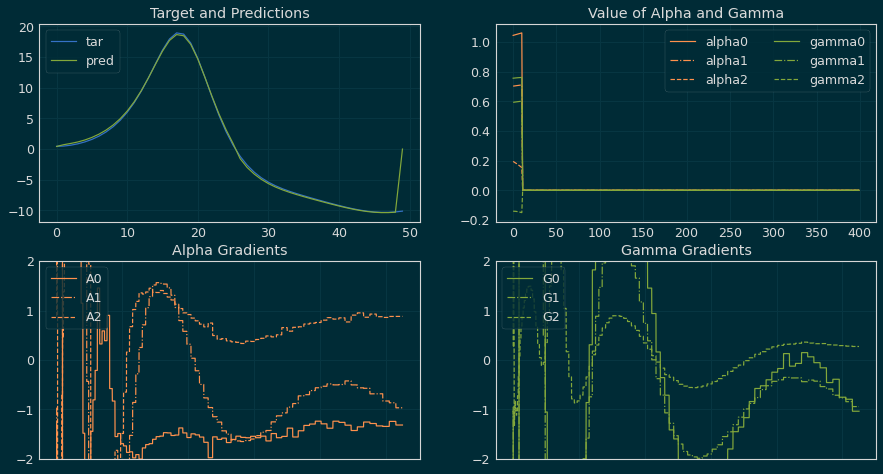

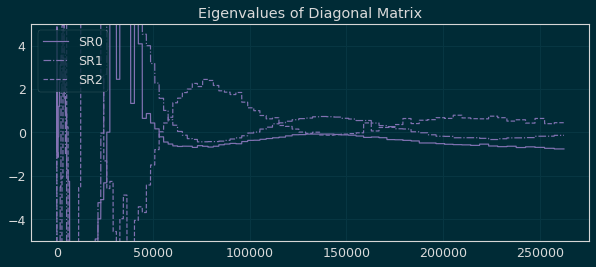

Eigenvals tensor([0.5509, 0.9591, 0.1948])
Eigenvals tensor([0.5594, 0.9595, 0.1909])
Eigenvals tensor([0.5684, 0.9599, 0.1873])
Eigenvals tensor([0.5777, 0.9604, 0.1836])
Eigenvals tensor([0.5874, 0.9609, 0.1800])
Eigenvals tensor([0.5976, 0.9613, 0.1766])
Eigenvals tensor([0.6084, 0.9618, 0.1733])
Eigenvals tensor([0.6200, 0.9623, 0.1703])
Eigenvals tensor([0.6323, 0.9627, 0.1674])
Eigenvals tensor([0.6455, 0.9633, 0.1647])
Epoch: 20


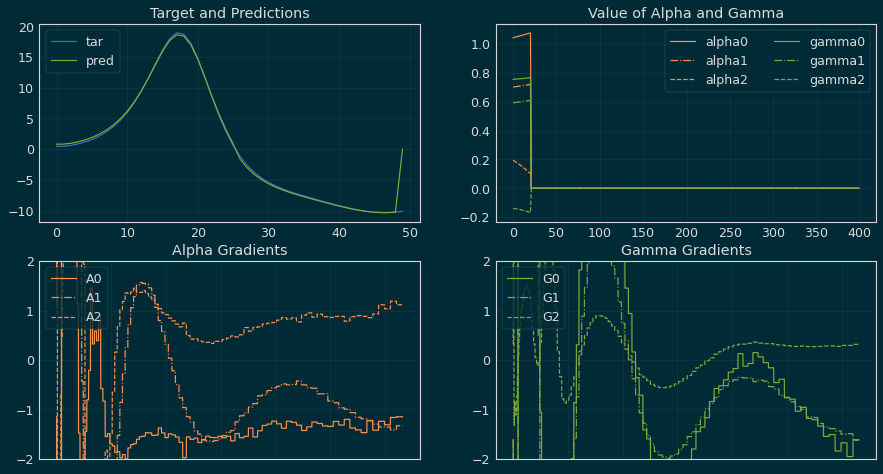

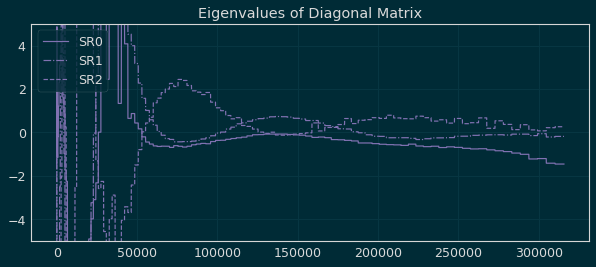

Eigenvals tensor([0.6598, 0.9638, 0.1620])
Eigenvals tensor([0.6743, 0.9643, 0.1596])
Eigenvals tensor([0.6902, 0.9649, 0.1575])
Eigenvals tensor([0.7080, 0.9656, 0.1553])
Eigenvals tensor([0.7281, 0.9665, 0.1535])
Eigenvals tensor([0.7502, 0.9674, 0.1520])
Eigenvals tensor([0.7759, 0.9687, 0.1508])
Eigenvals tensor([0.8059, 0.9703, 0.1501])
Eigenvals tensor([0.8425, 0.9723, 0.1501])
Eigenvals tensor([0.8796, 0.9741, 0.1508])
Epoch: 30


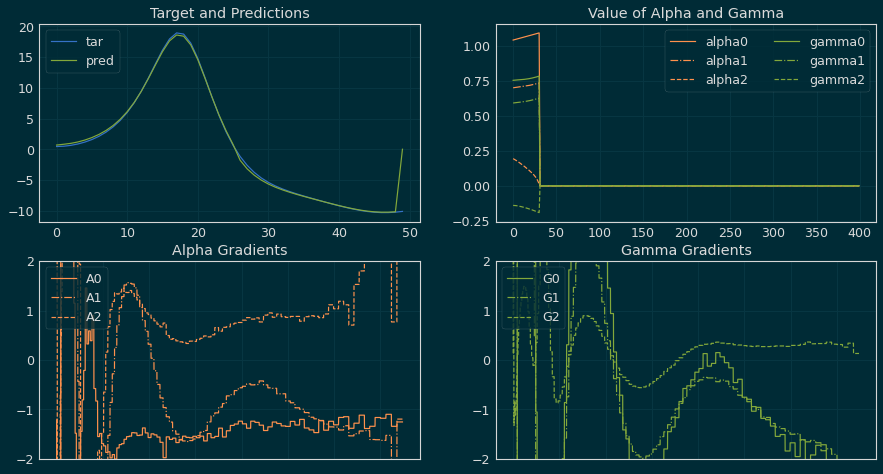

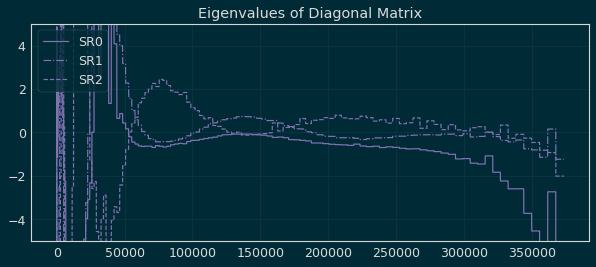

Eigenvals tensor([0.9277, 0.9764, 0.1530])
Eigenvals tensor([0.9757, 0.9780, 0.1564])
Eigenvals tensor([1.0424, 0.9807, 0.1642])
Eigenvals tensor([1.1180, 0.9925, 0.1817])
Eigenvals tensor([1.0656, 0.9405, 0.1299])
Eigenvals tensor([1.0195, 0.8946, 0.0847])
Eigenvals tensor([0.9783, 0.8538, 0.0443])
Eigenvals tensor([0.9412, 0.8172, 0.0078])
Eigenvals tensor([ 0.9077,  0.7845, -0.0253])
Eigenvals tensor([ 0.8776,  0.7551, -0.0553])
Epoch: 40


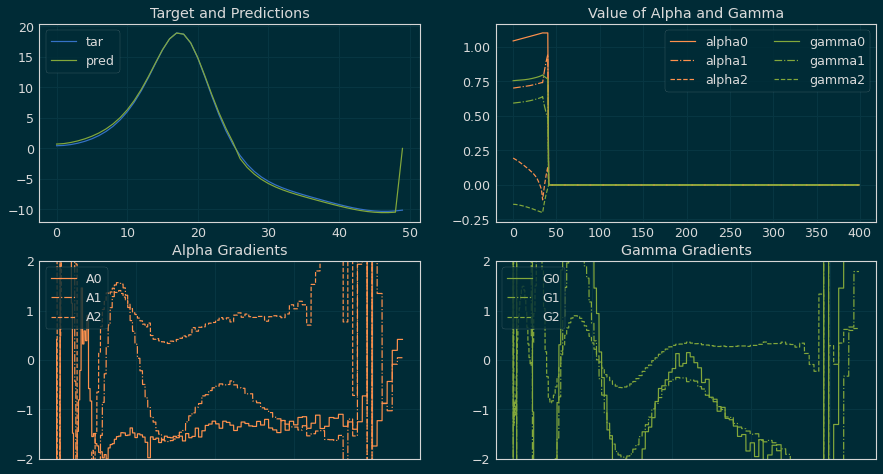

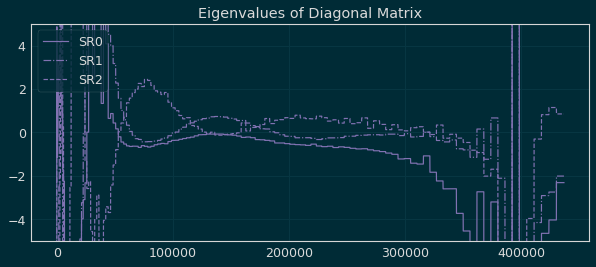

Eigenvals tensor([ 0.8504,  0.7288, -0.0825])
Eigenvals tensor([ 0.8258,  0.7052, -0.1072])
Eigenvals tensor([ 0.8036,  0.6839, -0.1297])
Eigenvals tensor([ 0.7836,  0.6648, -0.1500])
Eigenvals tensor([ 0.7655,  0.6475, -0.1685])
Eigenvals tensor([ 0.7492,  0.6320, -0.1852])
Eigenvals tensor([ 0.7345,  0.6180, -0.2004])
Eigenvals tensor([ 0.7211,  0.6053, -0.2141])
Eigenvals tensor([ 0.7091,  0.5939, -0.2266])
Eigenvals tensor([ 0.6982,  0.5835, -0.2379])
Epoch: 50


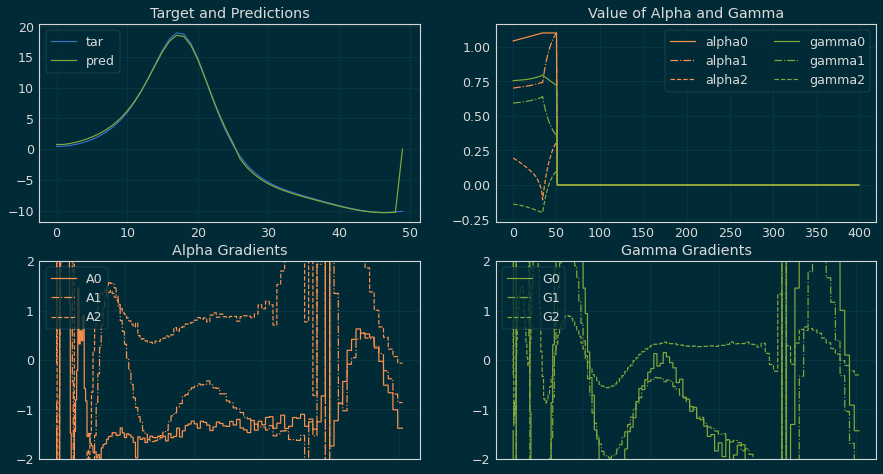

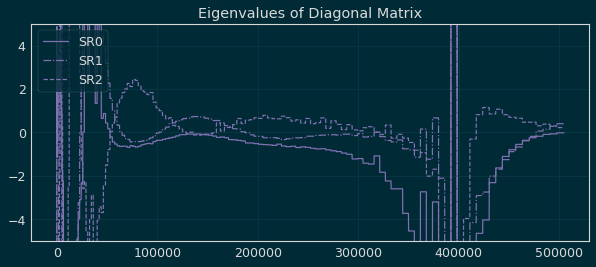

Eigenvals tensor([ 0.6884,  0.5741, -0.2481])
Eigenvals tensor([ 0.6795,  0.5655, -0.2574])
Eigenvals tensor([ 0.6715,  0.5578, -0.2657])
Eigenvals tensor([ 0.6643,  0.5507, -0.2734])
Eigenvals tensor([ 0.6577,  0.5442, -0.2803])
Eigenvals tensor([ 0.6518,  0.5384, -0.2866])
Eigenvals tensor([ 0.6465,  0.5330, -0.2923])
Eigenvals tensor([ 0.6416,  0.5281, -0.2975])
Eigenvals tensor([ 0.6373,  0.5236, -0.3022])
Eigenvals tensor([ 0.6333,  0.5195, -0.3065])
Epoch: 60


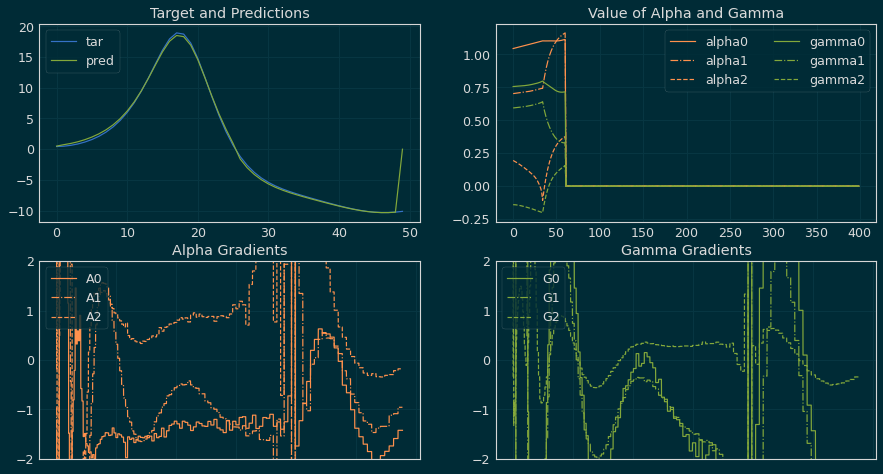

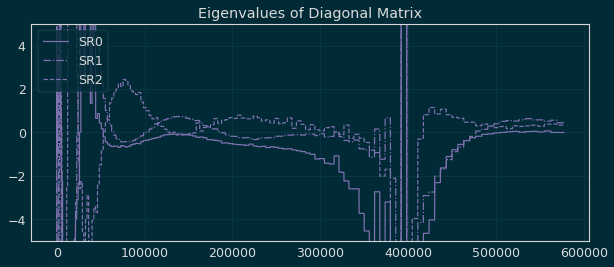

Eigenvals tensor([ 0.6298,  0.5157, -0.3105])
Eigenvals tensor([ 0.6266,  0.5123, -0.3141])
Eigenvals tensor([ 0.6237,  0.5092, -0.3174])
Eigenvals tensor([ 0.6211,  0.5063, -0.3204])
Eigenvals tensor([ 0.6187,  0.5037, -0.3232])
Eigenvals tensor([ 0.6166,  0.5014, -0.3257])
Eigenvals tensor([ 0.6146,  0.4992, -0.3280])
Eigenvals tensor([ 0.6129,  0.4972, -0.3302])
Eigenvals tensor([ 0.6113,  0.4954, -0.3322])
Eigenvals tensor([ 0.6099,  0.4938, -0.3340])
Epoch: 70


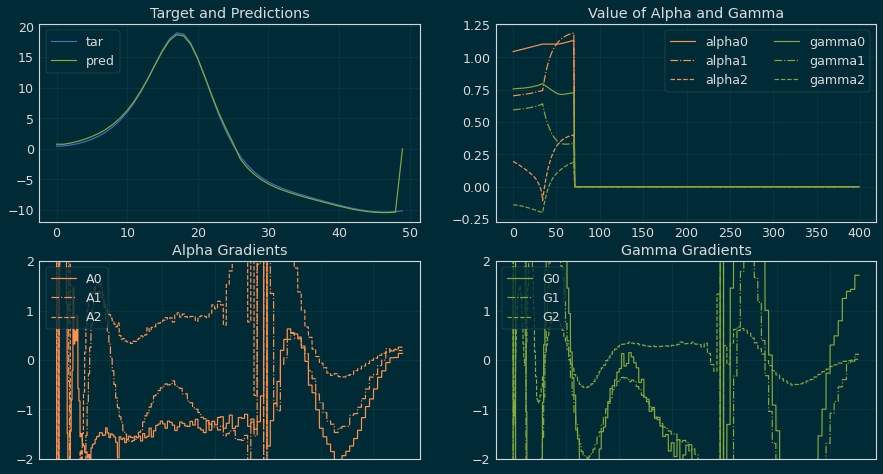

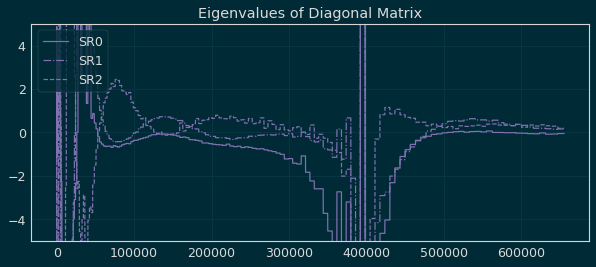

Eigenvals tensor([ 0.6086,  0.4923, -0.3356])
Eigenvals tensor([ 0.6075,  0.4909, -0.3372])
Eigenvals tensor([ 0.6064,  0.4896, -0.3386])
Eigenvals tensor([ 0.6055,  0.4884, -0.3399])
Eigenvals tensor([ 0.6047,  0.4874, -0.3411])
Eigenvals tensor([ 0.6039,  0.4864, -0.3423])
Eigenvals tensor([ 0.6032,  0.4854, -0.3434])
Eigenvals tensor([ 0.6026,  0.4845, -0.3444])
Eigenvals tensor([ 0.6020,  0.4837, -0.3454])
Eigenvals tensor([ 0.6015,  0.4829, -0.3463])
Epoch: 80


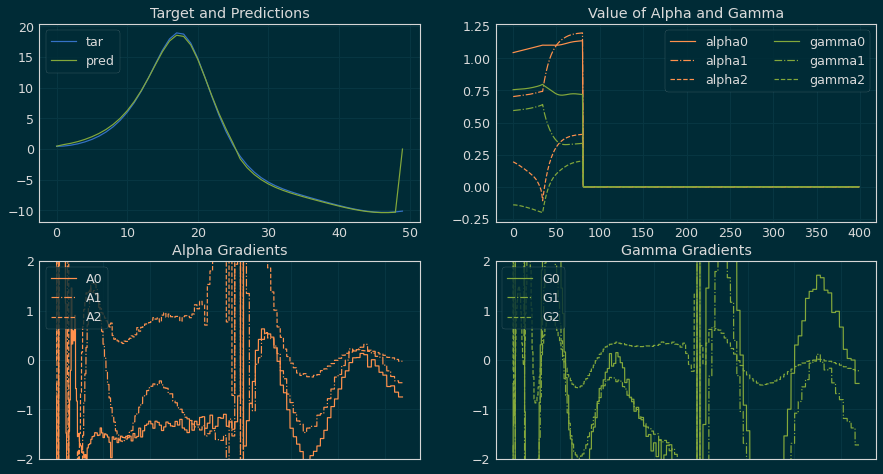

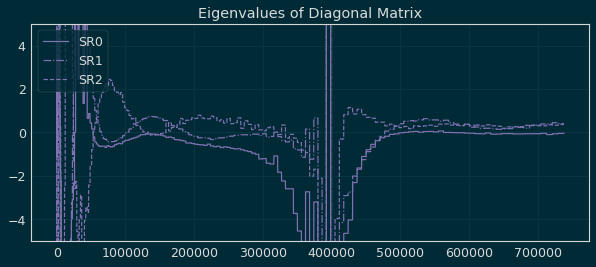

Eigenvals tensor([ 0.6011,  0.4821, -0.3471])
Eigenvals tensor([ 0.6007,  0.4814, -0.3480])
Eigenvals tensor([ 0.6003,  0.4806, -0.3488])
Eigenvals tensor([ 0.6000,  0.4799, -0.3496])
Eigenvals tensor([ 0.5997,  0.4793, -0.3503])
Eigenvals tensor([ 0.5994,  0.4786, -0.3511])
Eigenvals tensor([ 0.5992,  0.4779, -0.3518])
Eigenvals tensor([ 0.5989,  0.4773, -0.3525])
Eigenvals tensor([ 0.5987,  0.4767, -0.3532])
Eigenvals tensor([ 0.5986,  0.4760, -0.3539])
Epoch: 90


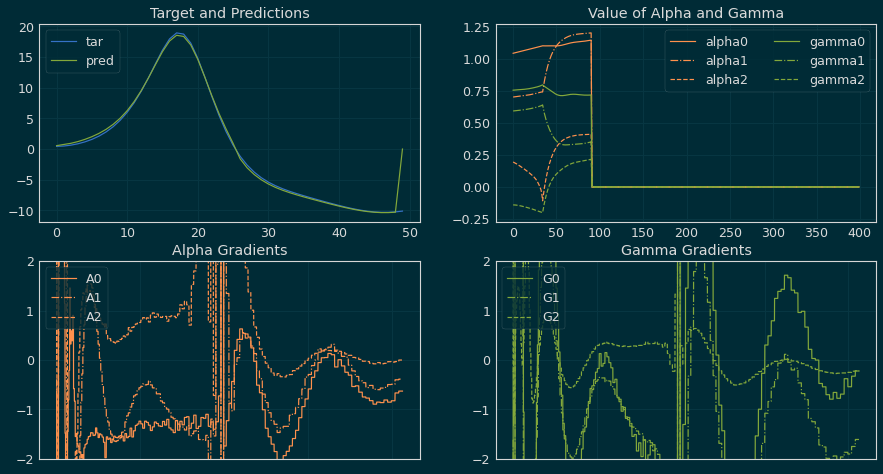

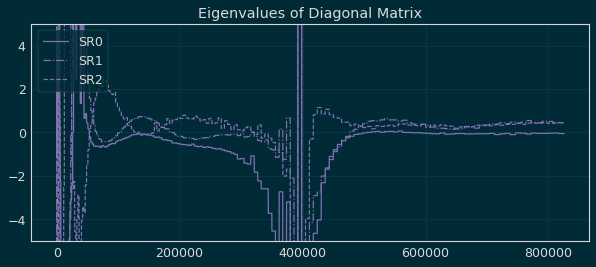

Eigenvals tensor([ 0.5984,  0.4754, -0.3546])
Eigenvals tensor([ 0.5983,  0.4748, -0.3553])
Eigenvals tensor([ 0.5981,  0.4743, -0.3559])
Eigenvals tensor([ 0.5980,  0.4737, -0.3566])
Eigenvals tensor([ 0.5979,  0.4732, -0.3572])
Eigenvals tensor([ 0.5978,  0.4726, -0.3579])
Eigenvals tensor([ 0.5978,  0.4721, -0.3585])
Eigenvals tensor([ 0.5977,  0.4716, -0.3591])
Eigenvals tensor([ 0.5976,  0.4711, -0.3598])
Eigenvals tensor([ 0.5976,  0.4705, -0.3604])
Epoch: 100


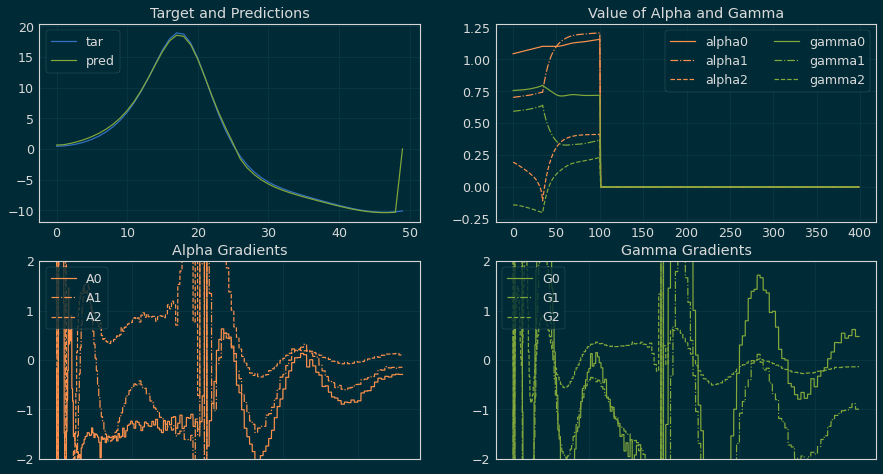

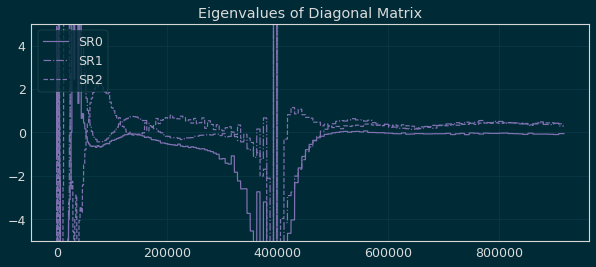

Eigenvals tensor([ 0.5975,  0.4701, -0.3610])
Eigenvals tensor([ 0.5975,  0.4696, -0.3616])
Eigenvals tensor([ 0.5975,  0.4691, -0.3623])
Eigenvals tensor([ 0.5974,  0.4686, -0.3629])
Eigenvals tensor([ 0.5974,  0.4681, -0.3635])
Eigenvals tensor([ 0.5974,  0.4676, -0.3642])
Eigenvals tensor([ 0.5974,  0.4671, -0.3648])
Eigenvals tensor([ 0.5973,  0.4665, -0.3655])
Eigenvals tensor([ 0.5973,  0.4660, -0.3662])
Eigenvals tensor([ 0.5973,  0.4655, -0.3669])
Epoch: 110


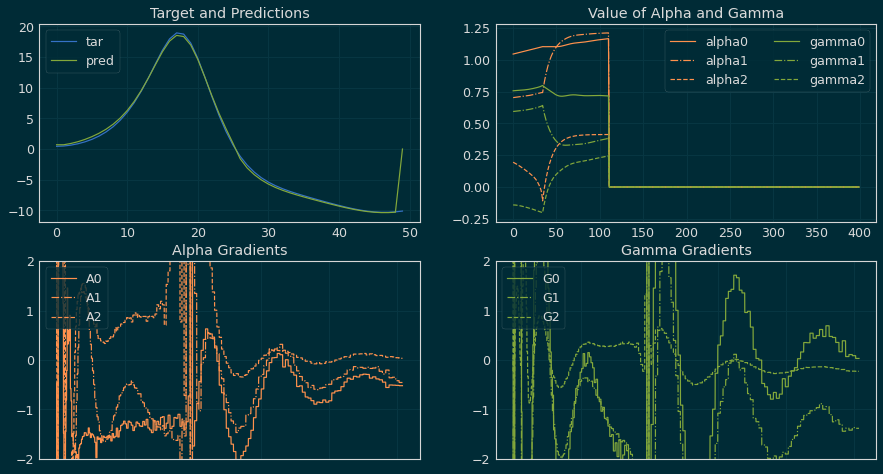

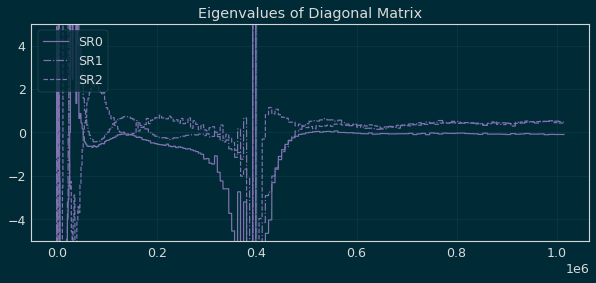

Eigenvals tensor([ 0.5973,  0.4650, -0.3675])
Eigenvals tensor([ 0.5973,  0.4644, -0.3682])
Eigenvals tensor([ 0.5973,  0.4638, -0.3689])
Eigenvals tensor([ 0.5973,  0.4633, -0.3696])
Eigenvals tensor([ 0.5973,  0.4627, -0.3703])
Eigenvals tensor([ 0.5973,  0.4621, -0.3710])
Eigenvals tensor([ 0.5973,  0.4615, -0.3717])
Eigenvals tensor([ 0.5973,  0.4609, -0.3724])
Eigenvals tensor([ 0.5973,  0.4603, -0.3732])
Eigenvals tensor([ 0.5973,  0.4597, -0.3739])
Epoch: 120


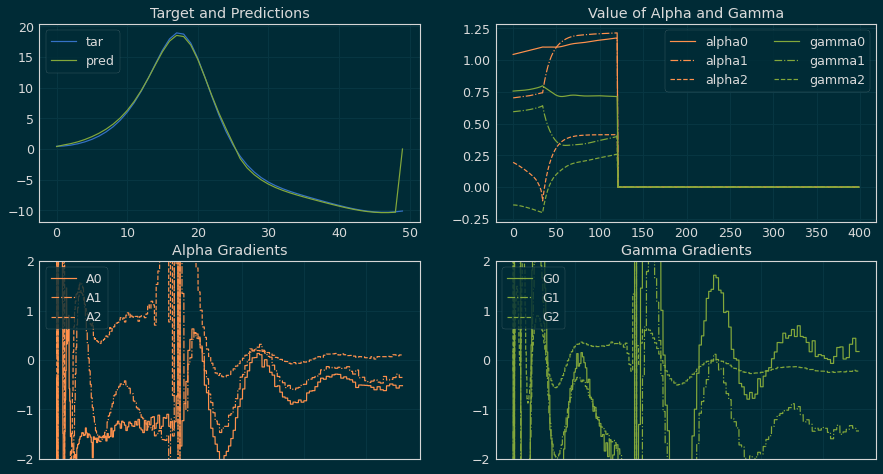

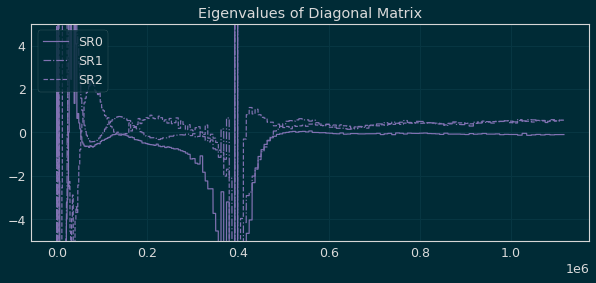

Eigenvals tensor([ 0.5974,  0.4591, -0.3746])
Eigenvals tensor([ 0.5974,  0.4585, -0.3754])
Eigenvals tensor([ 0.5974,  0.4579, -0.3762])
Eigenvals tensor([ 0.5974,  0.4573, -0.3769])
Eigenvals tensor([ 0.5974,  0.4567, -0.3777])
Eigenvals tensor([ 0.5974,  0.4561, -0.3785])
Eigenvals tensor([ 0.5975,  0.4555, -0.3793])
Eigenvals tensor([ 0.5975,  0.4549, -0.3801])
Eigenvals tensor([ 0.5975,  0.4543, -0.3810])
Eigenvals tensor([ 0.5975,  0.4537, -0.3818])
Epoch: 130


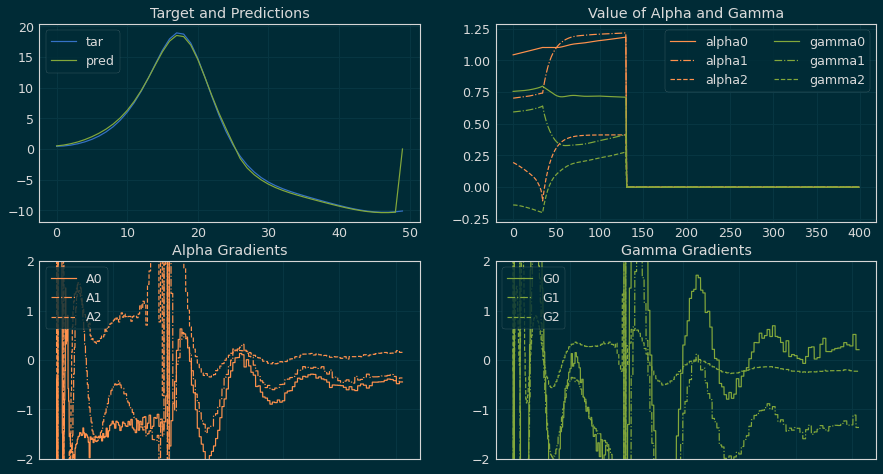

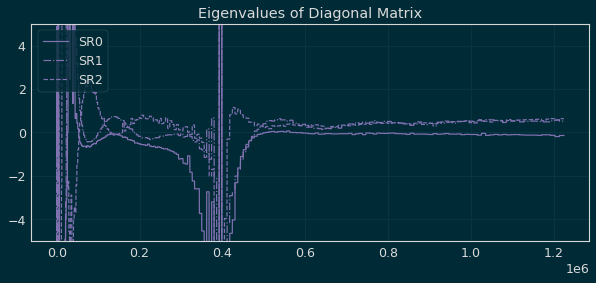

Eigenvals tensor([ 0.5975,  0.4530, -0.3827])
Eigenvals tensor([ 0.5976,  0.4524, -0.3835])
Eigenvals tensor([ 0.5976,  0.4518, -0.3844])
Eigenvals tensor([ 0.5976,  0.4511, -0.3853])
Eigenvals tensor([ 0.5976,  0.4505, -0.3862])
Eigenvals tensor([ 0.5977,  0.4499, -0.3871])
Eigenvals tensor([ 0.5977,  0.4492, -0.3880])
Eigenvals tensor([ 0.5977,  0.4485, -0.3889])
Eigenvals tensor([ 0.5978,  0.4479, -0.3898])
Eigenvals tensor([ 0.5978,  0.4472, -0.3907])
Epoch: 140


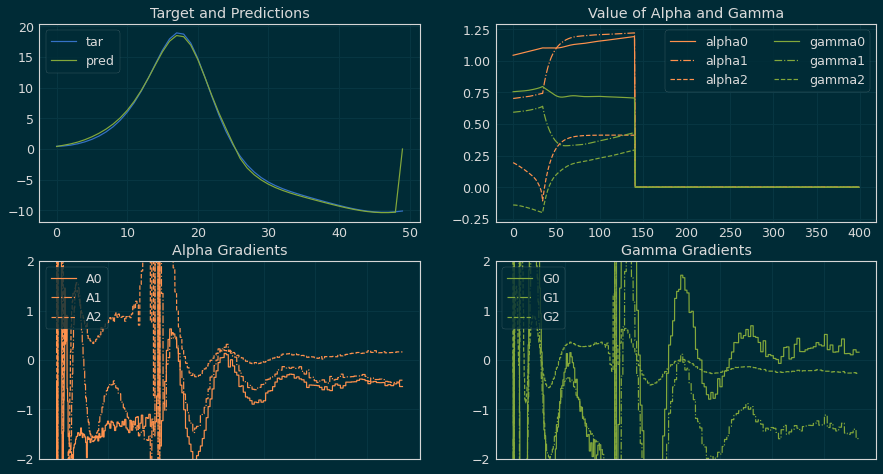

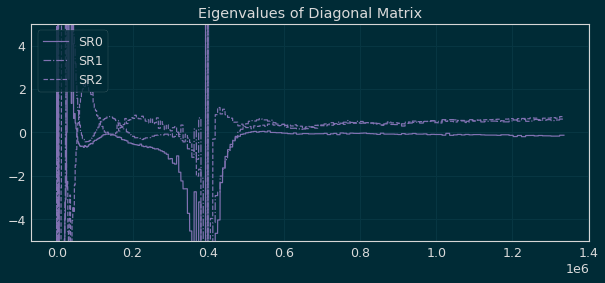

Eigenvals tensor([ 0.5978,  0.4465, -0.3917])
Eigenvals tensor([ 0.5978,  0.4458, -0.3927])
Eigenvals tensor([ 0.5979,  0.4452, -0.3937])
Eigenvals tensor([ 0.5979,  0.4445, -0.3947])
Eigenvals tensor([ 0.5979,  0.4438, -0.3957])
Eigenvals tensor([ 0.5980,  0.4431, -0.3967])
Eigenvals tensor([ 0.5980,  0.4424, -0.3978])
Eigenvals tensor([ 0.5980,  0.4417, -0.3988])
Eigenvals tensor([ 0.5981,  0.4410, -0.3999])
Eigenvals tensor([ 0.5981,  0.4403, -0.4010])
Epoch: 150


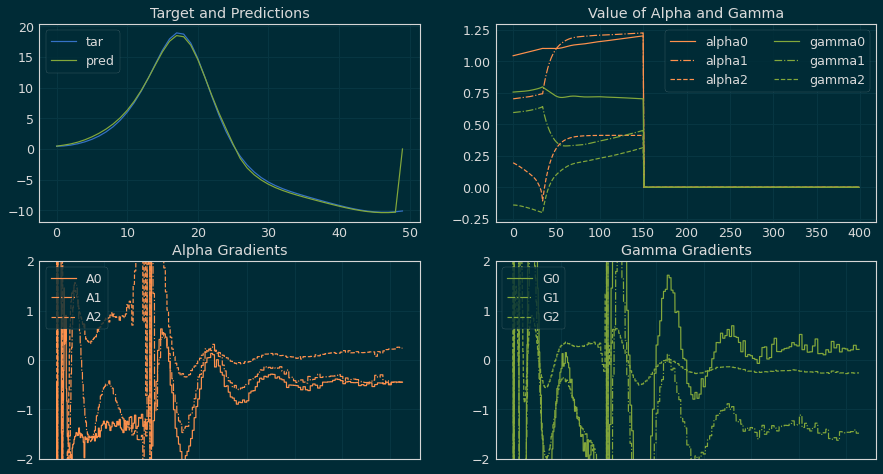

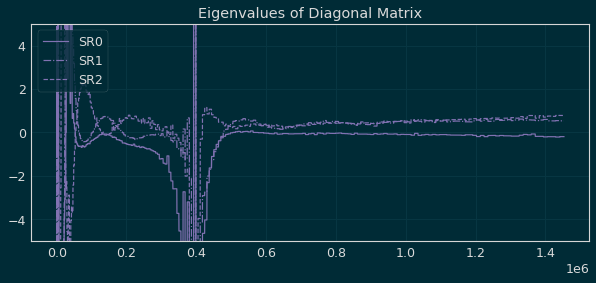

Eigenvals tensor([ 0.5981,  0.4396, -0.4021])
Eigenvals tensor([ 0.5982,  0.4389, -0.4032])
Eigenvals tensor([ 0.5982,  0.4382, -0.4043])
Eigenvals tensor([ 0.5982,  0.4375, -0.4054])
Eigenvals tensor([ 0.5983,  0.4368, -0.4065])
Eigenvals tensor([ 0.5983,  0.4361, -0.4077])
Eigenvals tensor([ 0.5984,  0.4354, -0.4088])
Eigenvals tensor([ 0.5984,  0.4348, -0.4100])
Eigenvals tensor([ 0.5985,  0.4341, -0.4111])
Eigenvals tensor([ 0.5985,  0.4334, -0.4123])
Epoch: 160


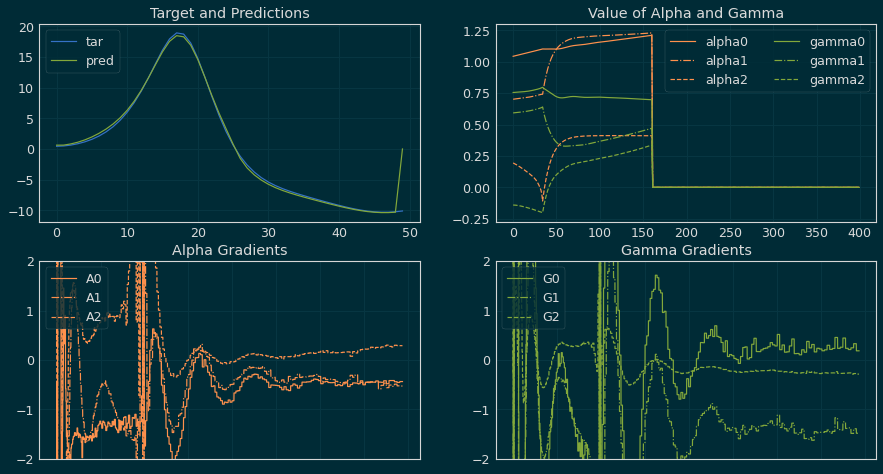

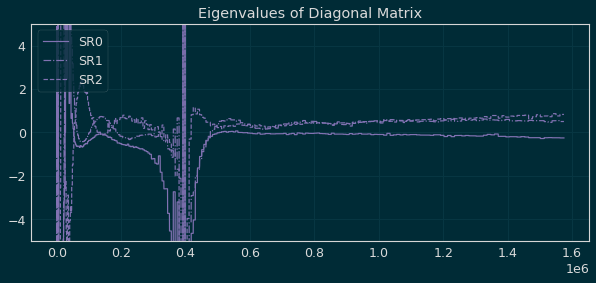

Eigenvals tensor([ 0.5986,  0.4327, -0.4135])
Eigenvals tensor([ 0.5986,  0.4320, -0.4147])
Eigenvals tensor([ 0.5987,  0.4314, -0.4159])
Eigenvals tensor([ 0.5987,  0.4307, -0.4172])
Eigenvals tensor([ 0.5988,  0.4300, -0.4185])
Eigenvals tensor([ 0.5988,  0.4294, -0.4198])
Eigenvals tensor([ 0.5989,  0.4287, -0.4211])
Eigenvals tensor([ 0.5989,  0.4280, -0.4224])
Eigenvals tensor([ 0.5990,  0.4274, -0.4238])
Eigenvals tensor([ 0.5991,  0.4267, -0.4252])
Epoch: 170


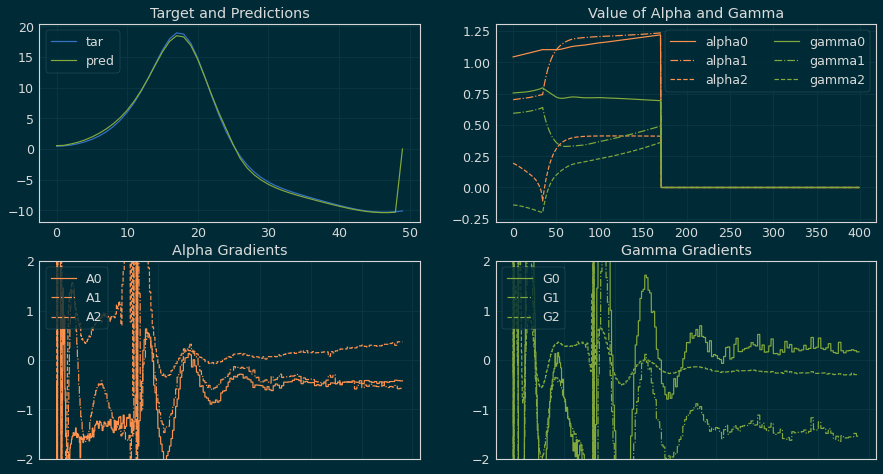

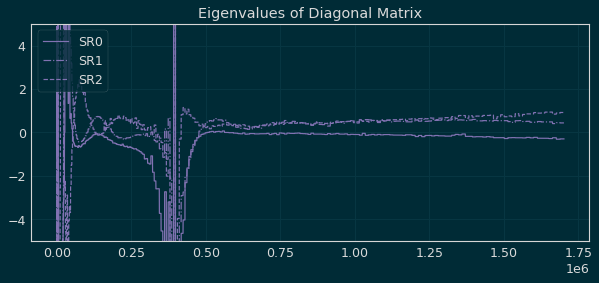

Eigenvals tensor([ 0.5991,  0.4261, -0.4265])
Eigenvals tensor([ 0.5992,  0.4255, -0.4279])
Eigenvals tensor([ 0.5992,  0.4248, -0.4294])
Eigenvals tensor([ 0.5993,  0.4242, -0.4308])
Eigenvals tensor([ 0.5994,  0.4236, -0.4322])
Eigenvals tensor([ 0.5994,  0.4230, -0.4337])
Eigenvals tensor([ 0.5995,  0.4223, -0.4352])
Eigenvals tensor([ 0.5996,  0.4217, -0.4368])
Eigenvals tensor([ 0.5996,  0.4211, -0.4383])
Eigenvals tensor([ 0.5997,  0.4205, -0.4399])
Epoch: 180


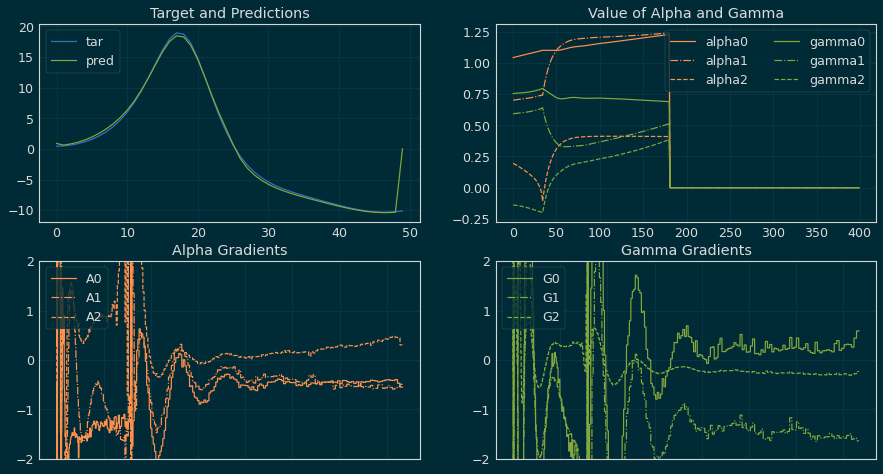

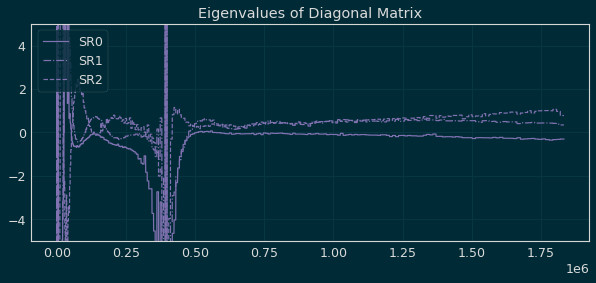

Eigenvals tensor([ 0.5998,  0.4199, -0.4414])
Eigenvals tensor([ 0.5998,  0.4194, -0.4429])
Eigenvals tensor([ 0.5999,  0.4188, -0.4445])
Eigenvals tensor([ 0.6000,  0.4182, -0.4461])
Eigenvals tensor([ 0.6001,  0.4177, -0.4477])
Eigenvals tensor([ 0.6001,  0.4171, -0.4493])
Eigenvals tensor([ 0.6002,  0.4166, -0.4509])
Eigenvals tensor([ 0.6003,  0.4161, -0.4525])
Eigenvals tensor([ 0.6004,  0.4155, -0.4541])
Eigenvals tensor([ 0.6005,  0.4150, -0.4558])
Epoch: 190


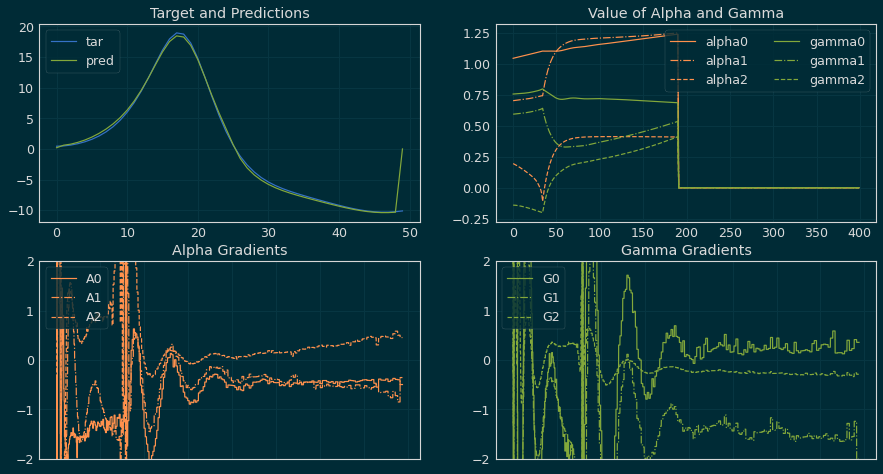

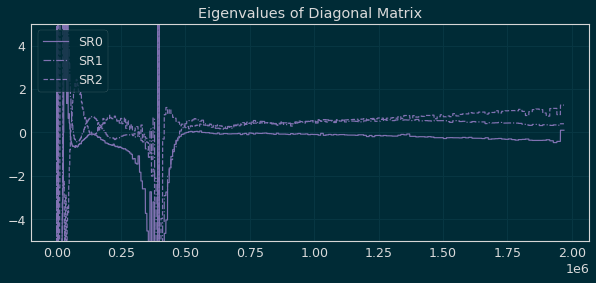

Eigenvals tensor([ 0.6006,  0.4145, -0.4574])
Eigenvals tensor([ 0.6006,  0.4140, -0.4591])
Eigenvals tensor([ 0.6007,  0.4135, -0.4609])
Eigenvals tensor([ 0.6008,  0.4130, -0.4626])
Eigenvals tensor([ 0.6009,  0.4125, -0.4644])
Eigenvals tensor([ 0.6010,  0.4120, -0.4662])
Eigenvals tensor([ 0.6011,  0.4116, -0.4680])
Eigenvals tensor([ 0.6011,  0.4111, -0.4699])
Eigenvals tensor([ 0.6012,  0.4106, -0.4718])
Eigenvals tensor([ 0.6013,  0.4102, -0.4737])
Epoch: 200


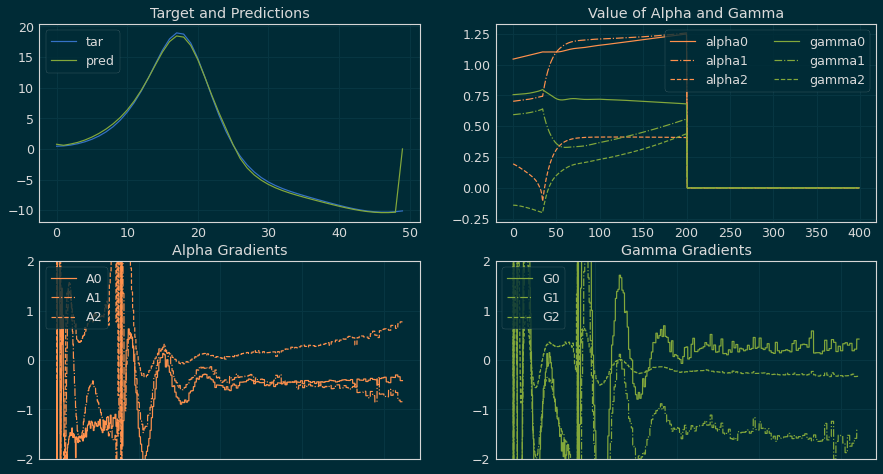

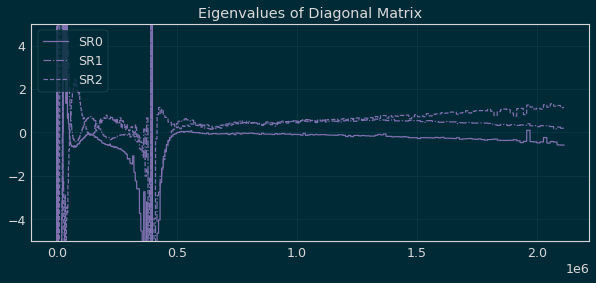

Eigenvals tensor([ 0.6014,  0.4098, -0.4756])
Eigenvals tensor([ 0.6015,  0.4094, -0.4776])
Eigenvals tensor([ 0.6017,  0.4090, -0.4795])
Eigenvals tensor([ 0.6018,  0.4087, -0.4815])
Eigenvals tensor([ 0.6019,  0.4083, -0.4835])
Eigenvals tensor([ 0.6020,  0.4080, -0.4854])
Eigenvals tensor([ 0.6021,  0.4076, -0.4874])
Eigenvals tensor([ 0.6022,  0.4073, -0.4895])
Eigenvals tensor([ 0.6023,  0.4069, -0.4916])
Eigenvals tensor([ 0.6024,  0.4066, -0.4936])
Epoch: 210


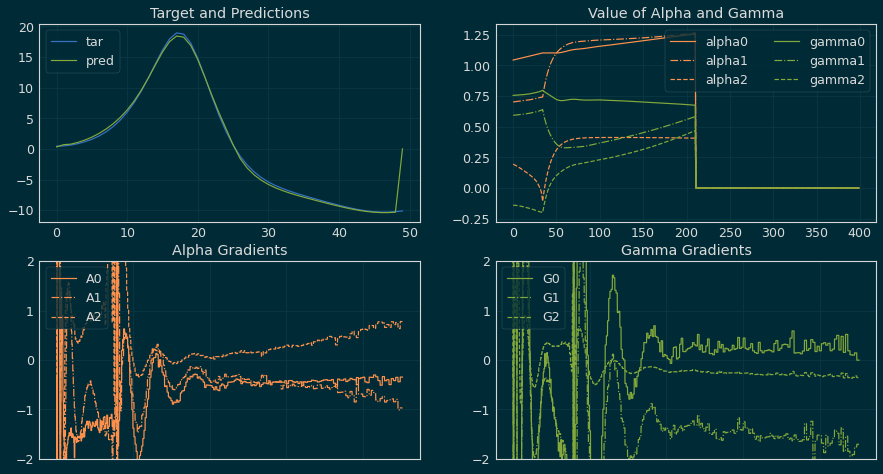

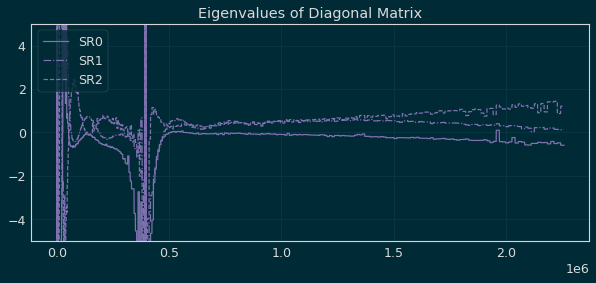

Eigenvals tensor([ 0.6026,  0.4063, -0.4957])
Eigenvals tensor([ 0.6027,  0.4060, -0.4977])
Eigenvals tensor([ 0.6028,  0.4057, -0.4997])
Eigenvals tensor([ 0.6029,  0.4055, -0.5017])
Eigenvals tensor([ 0.6031,  0.4052, -0.5038])
Eigenvals tensor([ 0.6032,  0.4050, -0.5059])
Eigenvals tensor([ 0.6034,  0.4047, -0.5081])
Eigenvals tensor([ 0.6035,  0.4045, -0.5104])
Eigenvals tensor([ 0.6036,  0.4043, -0.5127])
Eigenvals tensor([ 0.6038,  0.4041, -0.5151])
Epoch: 220


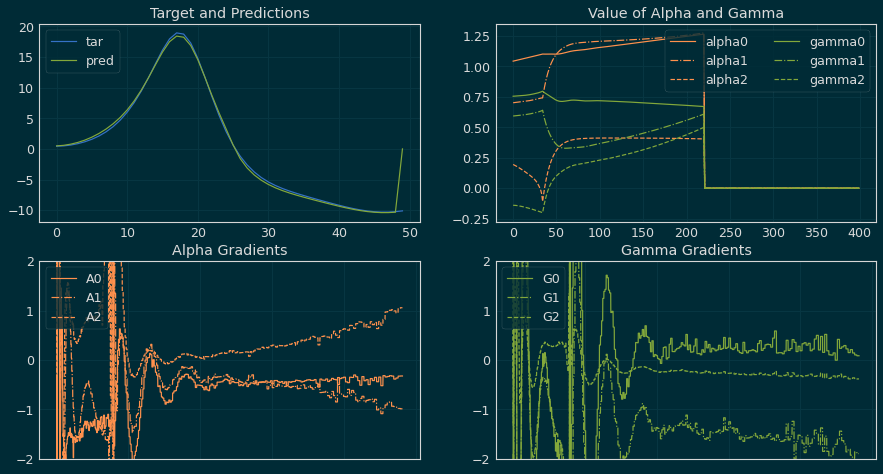

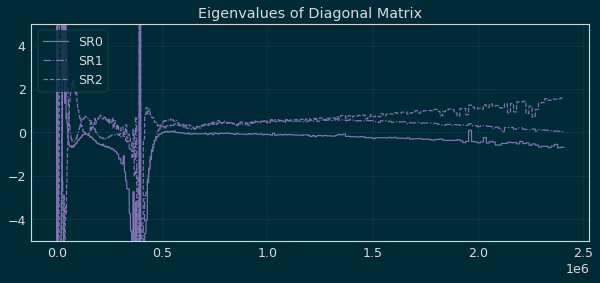

Eigenvals tensor([ 0.6039,  0.4039, -0.5175])
Eigenvals tensor([ 0.6041,  0.4038, -0.5200])
Eigenvals tensor([ 0.6043,  0.4036, -0.5224])
Eigenvals tensor([ 0.6044,  0.4035, -0.5247])
Eigenvals tensor([ 0.6046,  0.4034, -0.5270])
Eigenvals tensor([ 0.6047,  0.4033, -0.5293])
Eigenvals tensor([ 0.6049,  0.4032, -0.5317])
Eigenvals tensor([ 0.6051,  0.4032, -0.5342])
Eigenvals tensor([ 0.6053,  0.4031, -0.5367])
Eigenvals tensor([ 0.6054,  0.4031, -0.5392])
Epoch: 230


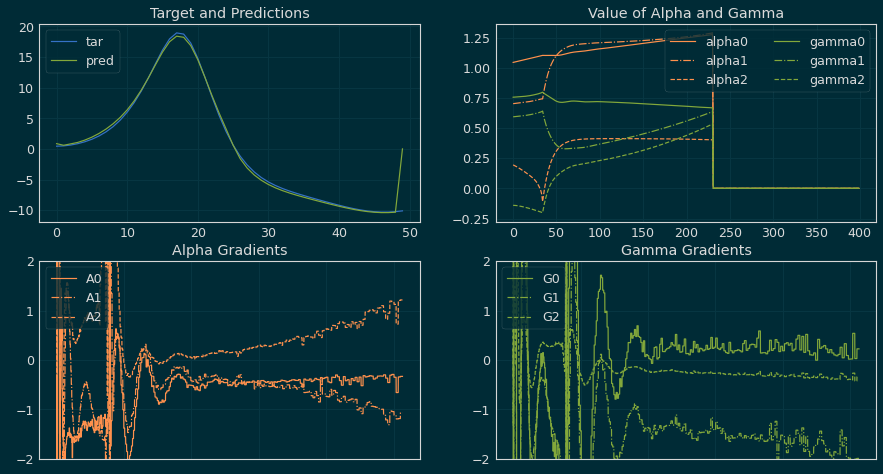

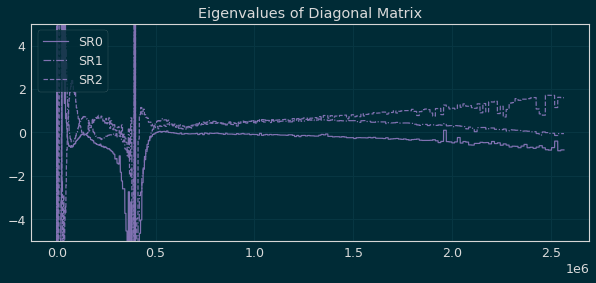

Eigenvals tensor([ 0.6056,  0.4031, -0.5418])
Eigenvals tensor([ 0.6058,  0.4031, -0.5444])
Eigenvals tensor([ 0.6060,  0.4031, -0.5471])
Eigenvals tensor([ 0.6062,  0.4031, -0.5498])
Eigenvals tensor([ 0.6064,  0.4031, -0.5526])
Eigenvals tensor([ 0.6066,  0.4032, -0.5555])
Eigenvals tensor([ 0.6068,  0.4032, -0.5584])
Eigenvals tensor([ 0.6070,  0.4033, -0.5612])
Eigenvals tensor([ 0.6072,  0.4034, -0.5642])
Eigenvals tensor([ 0.6074,  0.4035, -0.5671])
Epoch: 240


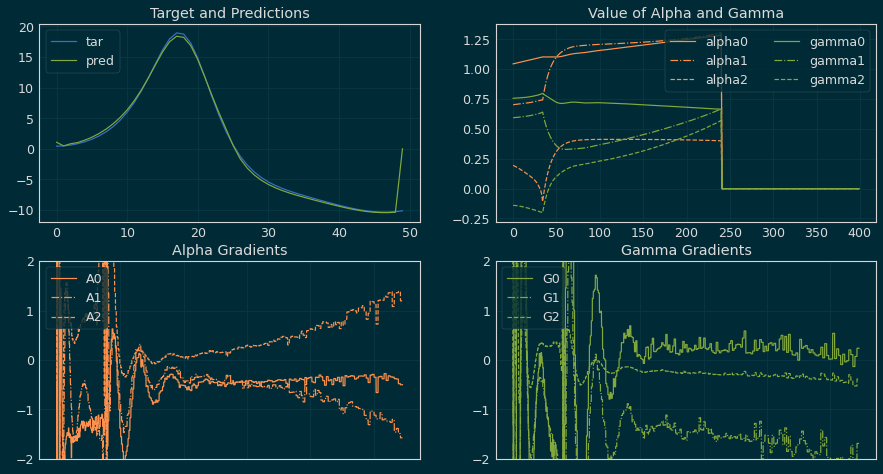

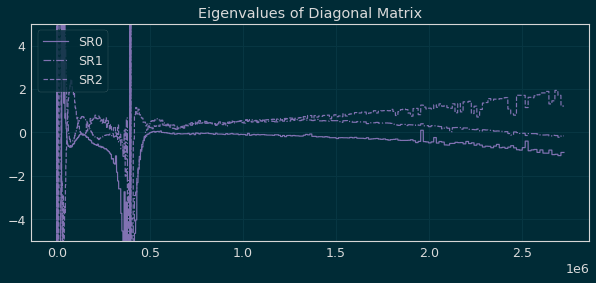

Eigenvals tensor([ 0.6077,  0.4037, -0.5700])
Eigenvals tensor([ 0.6079,  0.4038, -0.5729])
Eigenvals tensor([ 0.6081,  0.4040, -0.5760])
Eigenvals tensor([ 0.6084,  0.4041, -0.5791])
Eigenvals tensor([ 0.6086,  0.4043, -0.5823])
Eigenvals tensor([ 0.6089,  0.4045, -0.5855])
Eigenvals tensor([ 0.6091,  0.4048, -0.5887])
Eigenvals tensor([ 0.6094,  0.4050, -0.5919])
Eigenvals tensor([ 0.6096,  0.4053, -0.5950])
Eigenvals tensor([ 0.6099,  0.4057, -0.5983])
Epoch: 250


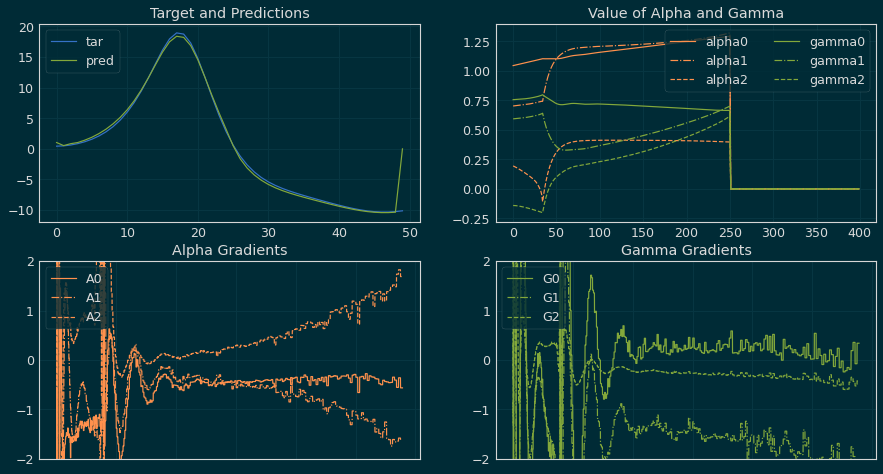

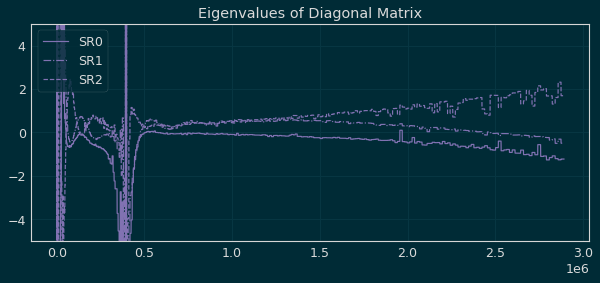

Eigenvals tensor([ 0.6102,  0.4060, -0.6015])
Eigenvals tensor([ 0.6105,  0.4064, -0.6048])
Eigenvals tensor([ 0.6108,  0.4068, -0.6082])
Eigenvals tensor([ 0.6111,  0.4072, -0.6116])
Eigenvals tensor([ 0.6114,  0.4077, -0.6151])
Eigenvals tensor([ 0.6118,  0.4081, -0.6187])
Eigenvals tensor([ 0.6121,  0.4086, -0.6224])
Eigenvals tensor([ 0.6124,  0.4090, -0.6262])
Eigenvals tensor([ 0.6128,  0.4095, -0.6300])
Eigenvals tensor([ 0.6131,  0.4100, -0.6340])
Epoch: 260


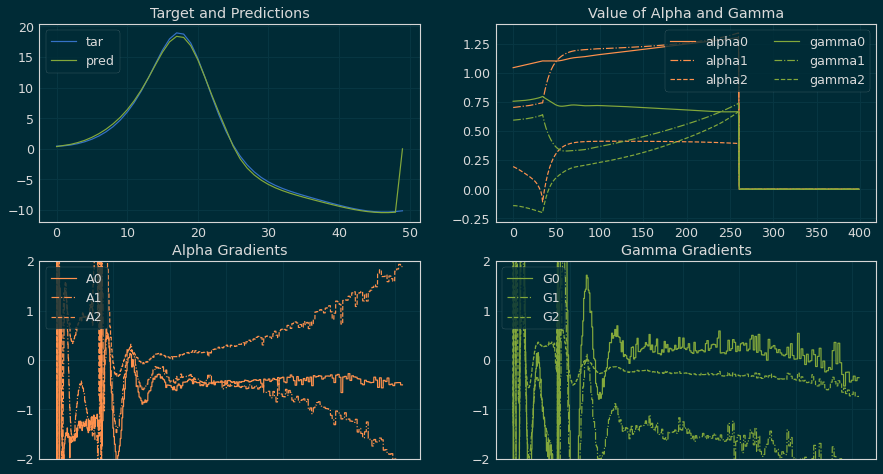

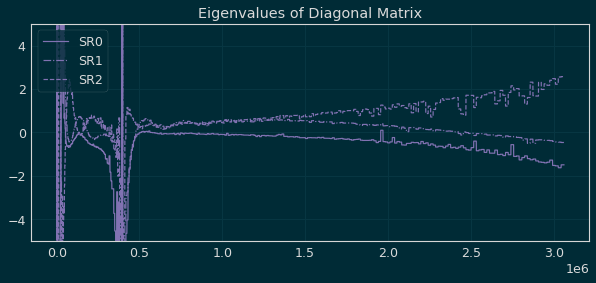

Eigenvals tensor([ 0.6135,  0.4106, -0.6381])
Eigenvals tensor([ 0.6139,  0.4111, -0.6421])
Eigenvals tensor([ 0.6143,  0.4117, -0.6462])
Eigenvals tensor([ 0.6147,  0.4123, -0.6504])
Eigenvals tensor([ 0.6151,  0.4130, -0.6546])
Eigenvals tensor([ 0.6155,  0.4136, -0.6590])
Eigenvals tensor([ 0.6159,  0.4143, -0.6635])
Eigenvals tensor([ 0.6163,  0.4151, -0.6679])
Eigenvals tensor([ 0.6168,  0.4160, -0.6725])
Eigenvals tensor([ 0.6172,  0.4168, -0.6772])
Epoch: 270


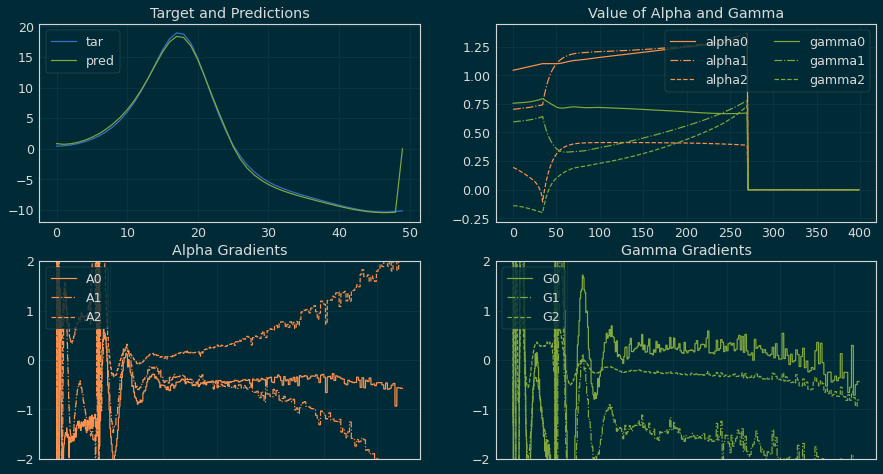

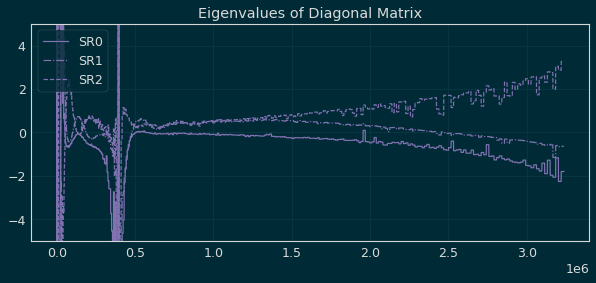

Eigenvals tensor([ 0.6177,  0.4177, -0.6820])
Eigenvals tensor([ 0.6182,  0.4185, -0.6870])
Eigenvals tensor([ 0.6186,  0.4194, -0.6920])
Eigenvals tensor([ 0.6192,  0.4203, -0.6970])
Eigenvals tensor([ 0.6197,  0.4213, -0.7021])
Eigenvals tensor([ 0.6203,  0.4222, -0.7072])
Eigenvals tensor([ 0.6208,  0.4232, -0.7124])
Eigenvals tensor([ 0.6213,  0.4243, -0.7177])
Eigenvals tensor([ 0.6219,  0.4253, -0.7233])
Eigenvals tensor([ 0.6225,  0.4264, -0.7287])
Epoch: 280


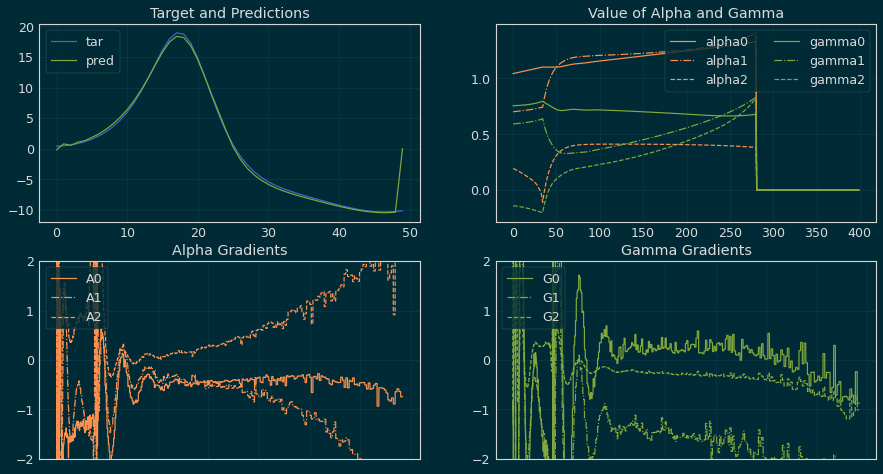

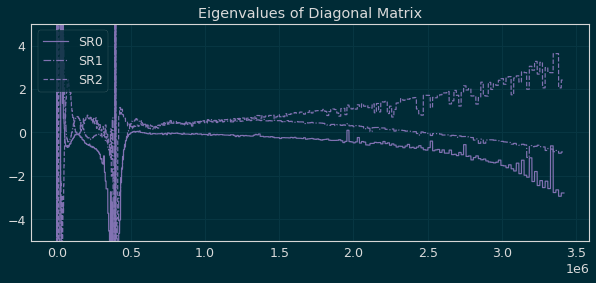

Eigenvals tensor([ 0.6231,  0.4276, -0.7341])
Eigenvals tensor([ 0.6238,  0.4288, -0.7397])
Eigenvals tensor([ 0.6244,  0.4300, -0.7454])
Eigenvals tensor([ 0.6251,  0.4312, -0.7507])
Eigenvals tensor([ 0.6258,  0.4325, -0.7564])
Eigenvals tensor([ 0.6265,  0.4338, -0.7623])
Eigenvals tensor([ 0.6273,  0.4351, -0.7683])
Eigenvals tensor([ 0.6280,  0.4364, -0.7745])
Eigenvals tensor([ 0.6289,  0.4379, -0.7811])
Eigenvals tensor([ 0.6297,  0.4395, -0.7880])
Epoch: 290


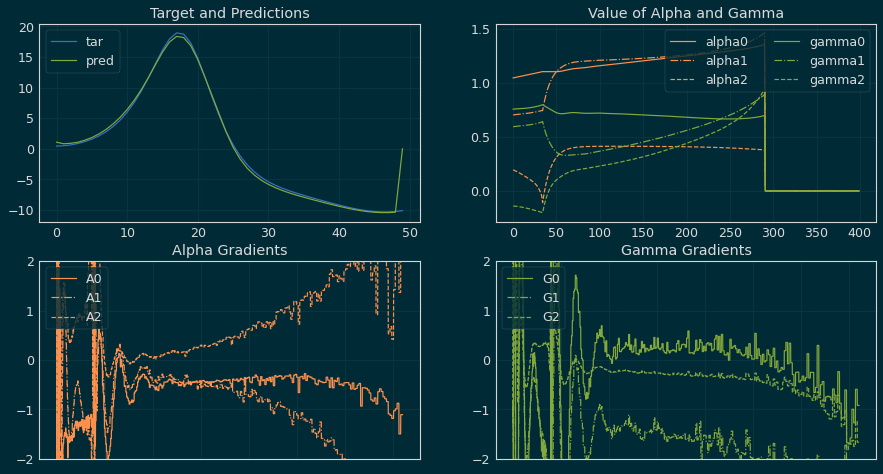

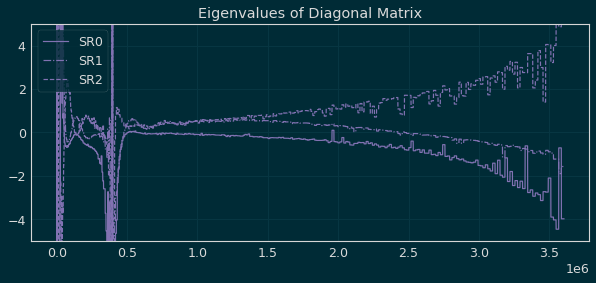

Eigenvals tensor([ 0.6305,  0.4412, -0.7954])
Eigenvals tensor([ 0.6314,  0.4429, -0.8031])
Eigenvals tensor([ 0.6323,  0.4448, -0.8108])
Eigenvals tensor([ 0.6334,  0.4467, -0.8184])
Eigenvals tensor([ 0.6345,  0.4487, -0.8262])
Eigenvals tensor([ 0.6357,  0.4507, -0.8336])
Eigenvals tensor([ 0.6369,  0.4528, -0.8403])
Eigenvals tensor([ 0.6383,  0.4551, -0.8471])
Eigenvals tensor([ 0.6399,  0.4576, -0.8544])
Eigenvals tensor([ 0.6416,  0.4601, -0.8625])
Epoch: 300


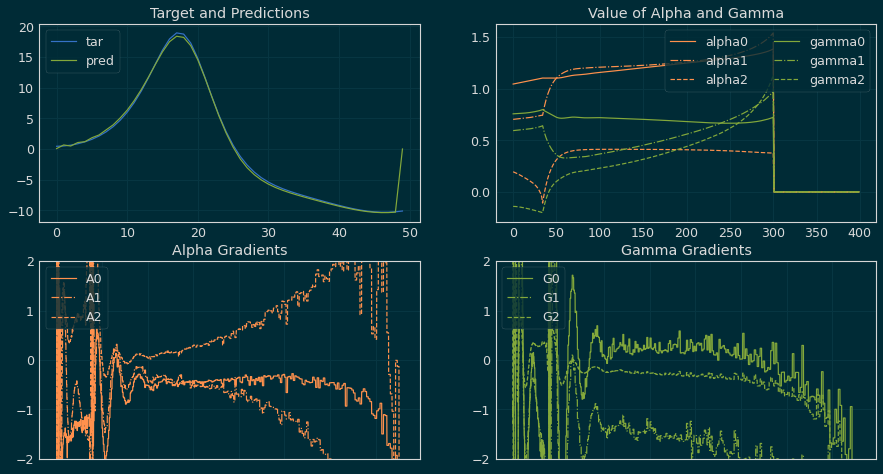

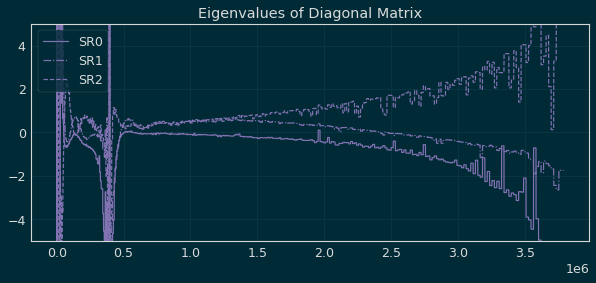

Eigenvals tensor([ 0.6434,  0.4627, -0.8711])
Eigenvals tensor([ 0.6454,  0.4651, -0.8796])
Eigenvals tensor([ 0.6476,  0.4669, -0.8874])
Eigenvals tensor([ 0.6499,  0.4682, -0.8958])
Eigenvals tensor([ 0.6526,  0.4696, -0.9052])
Eigenvals tensor([ 0.6556,  0.4707, -0.9135])
Eigenvals tensor([ 0.6590,  0.4719, -0.9233])
Eigenvals tensor([ 0.6628,  0.4744, -0.9333])
Eigenvals tensor([ 0.6667,  0.4754, -0.9440])
Eigenvals tensor([ 0.6712,  0.4790, -0.9554])
Epoch: 310


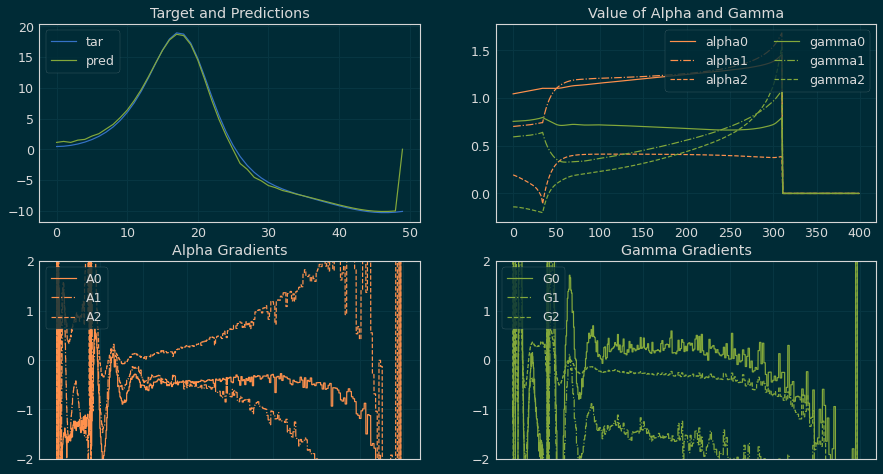

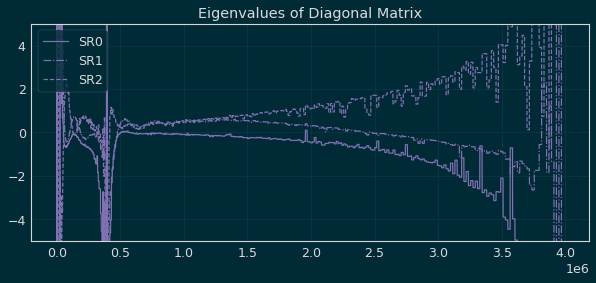

Eigenvals tensor([ 0.6755,  0.4805, -0.9679])
Eigenvals tensor([ 0.6802,  0.4832, -0.9796])
Eigenvals tensor([ 0.6861,  0.4887, -0.9967])
Eigenvals tensor([ 0.6903,  0.4888, -1.0068])
Eigenvals tensor([ 0.6962,  0.4940, -1.0174])
Eigenvals tensor([ 0.7034,  0.5022, -1.0277])
Eigenvals tensor([ 0.7069,  0.5006, -1.0249])
Eigenvals tensor([ 0.7105,  0.4994, -1.0289])
Eigenvals tensor([ 0.7160,  0.5046, -1.0364])
Eigenvals tensor([ 0.7226,  0.5136, -1.0463])
Epoch: 320


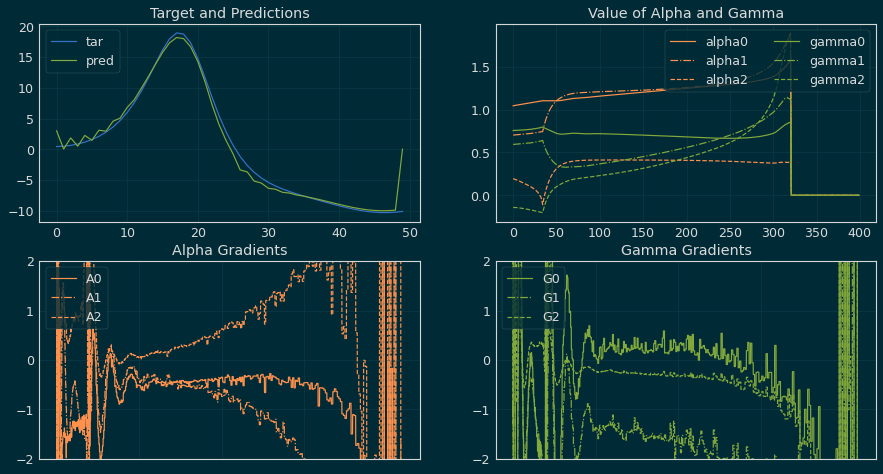

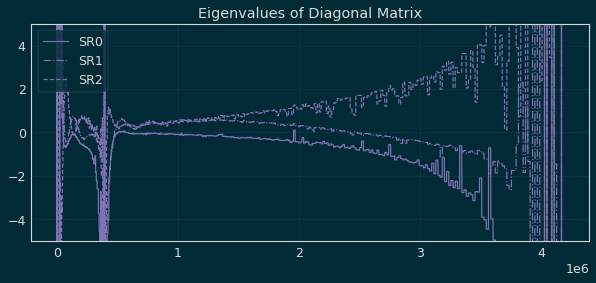

Eigenvals tensor([ 0.7278,  0.5187, -1.0531])
Eigenvals tensor([ 0.7311,  0.5186, -1.0552])
Eigenvals tensor([ 0.7353,  0.5218, -1.0631])
Eigenvals tensor([ 0.7402,  0.5311, -1.0780])
Eigenvals tensor([ 0.7456,  0.5381, -1.0964])
Eigenvals tensor([ 0.7479,  0.5349, -1.1081])
Eigenvals tensor([ 0.7519,  0.5369, -1.1250])
Eigenvals tensor([ 0.7580,  0.5437, -1.1452])
Eigenvals tensor([ 0.7573,  0.5335, -1.1513])
Eigenvals tensor([ 0.7594,  0.5352, -1.1612])
Epoch: 330


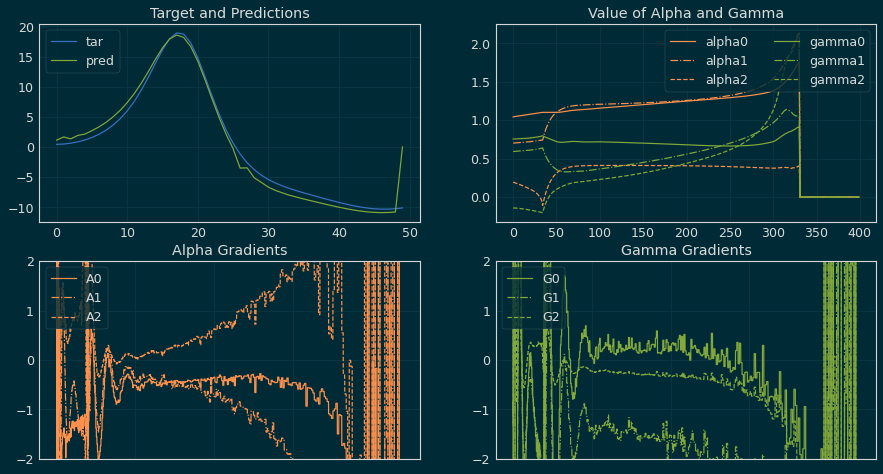

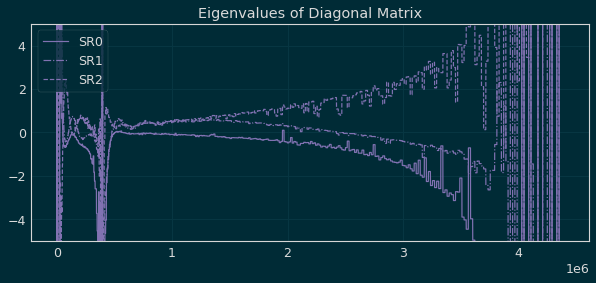

Eigenvals tensor([ 0.7640,  0.5474, -1.1782])
Eigenvals tensor([ 0.7639,  0.5449, -1.1914])
Eigenvals tensor([ 0.7595,  0.5298, -1.2015])
Eigenvals tensor([ 0.7568,  0.5198, -1.2172])
Eigenvals tensor([ 0.7568,  0.5190, -1.2426])
Eigenvals tensor([ 0.7574,  0.5192, -1.2746])
Eigenvals tensor([ 0.7549,  0.5134, -1.3064])
Eigenvals tensor([ 0.7471,  0.4952, -1.3288])
Eigenvals tensor([ 0.7420,  0.4828, -1.3558])
Eigenvals tensor([ 0.7410,  0.4805, -1.3896])
Epoch: 340


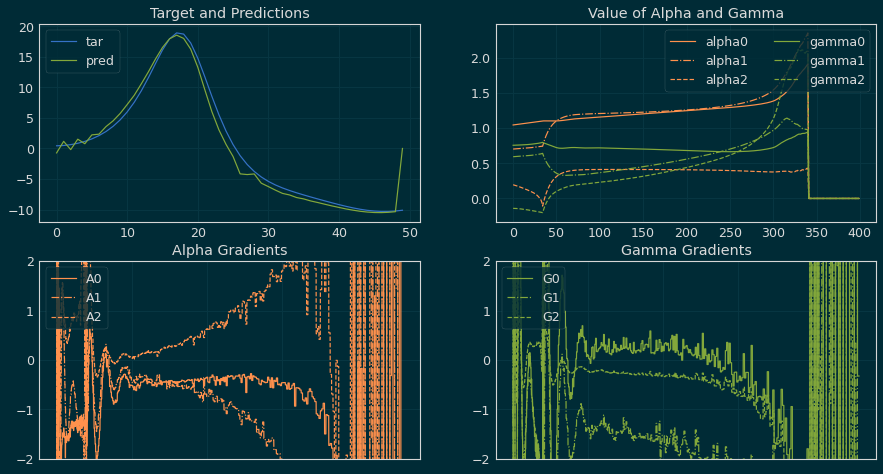

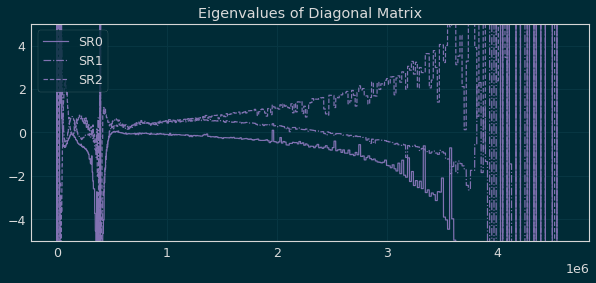

Eigenvals tensor([ 0.7422,  0.4812, -1.4239])
Eigenvals tensor([ 0.7284,  0.4487, -1.4138])
Eigenvals tensor([ 0.7211,  0.4303, -1.4143])
Eigenvals tensor([ 0.7194,  0.4259, -1.4242])
Eigenvals tensor([ 0.7223,  0.4314, -1.4426])
Eigenvals tensor([ 0.7241,  0.4329, -1.4610])
Eigenvals tensor([ 0.7149,  0.4139, -1.4593])
Eigenvals tensor([ 0.7016,  0.3867, -1.4557])
Eigenvals tensor([ 0.6919,  0.3653, -1.4616])
Eigenvals tensor([ 0.6875,  0.3554, -1.4798])
Epoch: 350


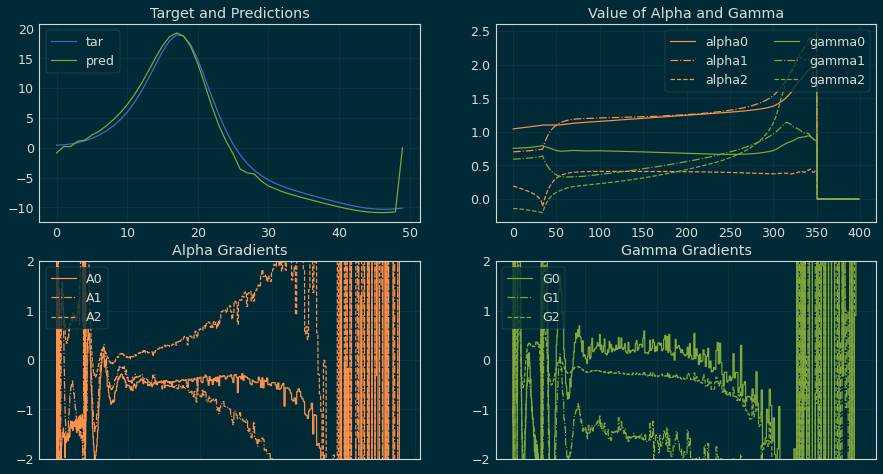

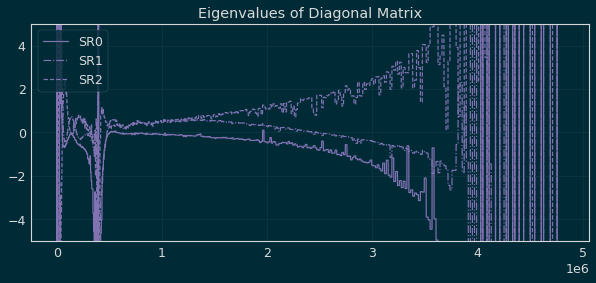

Eigenvals tensor([ 0.6879,  0.3544, -1.5073])
Eigenvals tensor([ 0.6887,  0.3535, -1.5322])
Eigenvals tensor([ 0.6818,  0.3405, -1.5373])
Eigenvals tensor([ 0.6696,  0.3177, -1.5308])
Eigenvals tensor([ 0.6607,  0.3003, -1.5229])
Eigenvals tensor([ 0.6596,  0.2957, -1.5293])
Eigenvals tensor([ 0.6626,  0.2975, -1.5417])
Eigenvals tensor([ 0.6570,  0.2858, -1.5365])
Eigenvals tensor([ 0.6461,  0.2662, -1.5220])
Eigenvals tensor([ 0.6427,  0.2591, -1.5216])
Epoch: 360


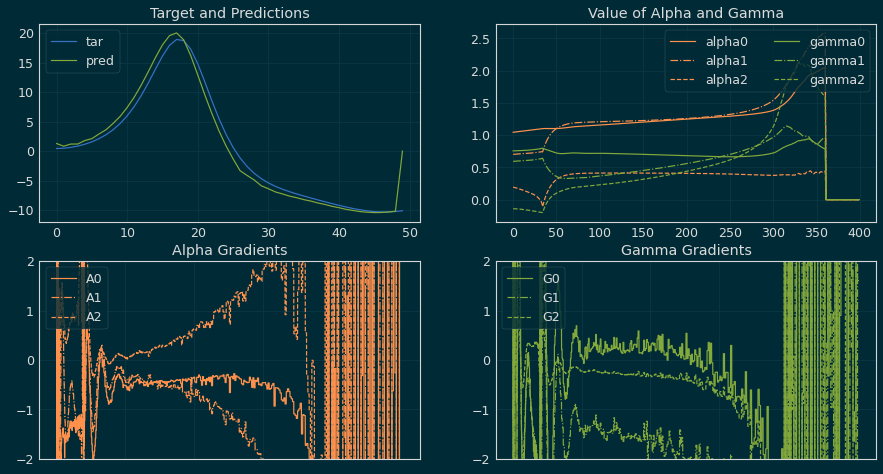

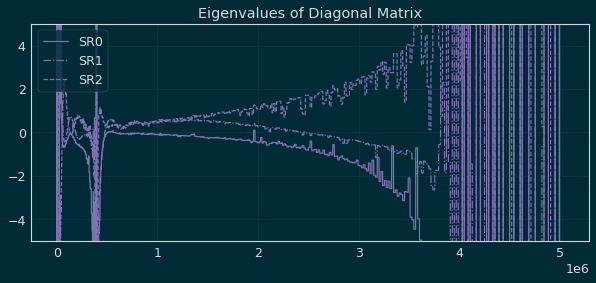

Eigenvals tensor([ 0.6461,  0.2631, -1.5336])
Eigenvals tensor([ 0.6443,  0.2595, -1.5349])
Eigenvals tensor([ 0.6360,  0.2461, -1.5226])
Eigenvals tensor([ 0.6314,  0.2384, -1.5167])
Eigenvals tensor([ 0.6336,  0.2407, -1.5235])
Eigenvals tensor([ 0.6333,  0.2408, -1.5259])
Eigenvals tensor([ 0.6275,  0.2323, -1.5172])
Eigenvals tensor([ 0.6218,  0.2230, -1.5086])
Eigenvals tensor([ 0.6204,  0.2201, -1.5091])
Eigenvals tensor([ 0.6217,  0.2205, -1.5147])
Epoch: 370


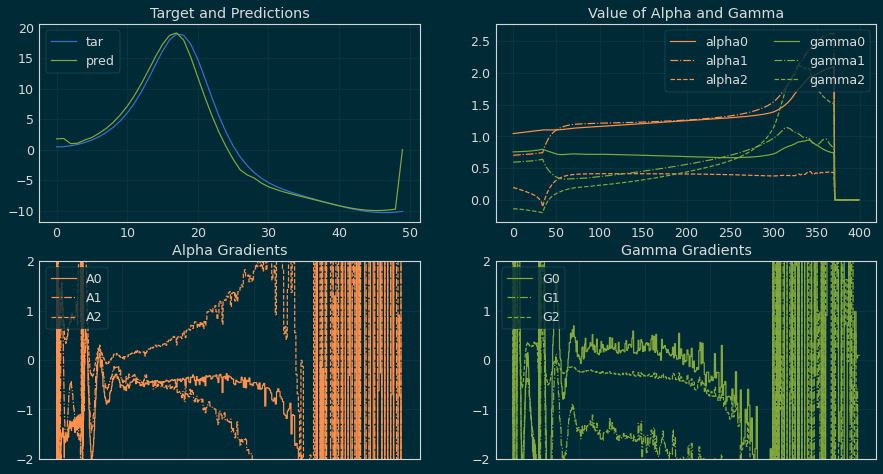

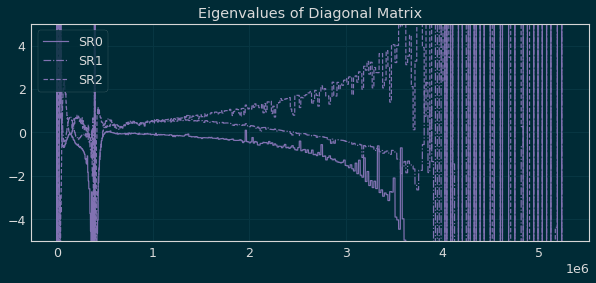

Eigenvals tensor([ 0.6203,  0.2163, -1.5139])
Eigenvals tensor([ 0.6158,  0.2067, -1.5064])
Eigenvals tensor([ 0.6132,  0.1999, -1.5018])
Eigenvals tensor([ 0.6143,  0.1986, -1.5041])
Eigenvals tensor([ 0.6150,  0.1966, -1.5060])
Eigenvals tensor([ 0.6119,  0.1886, -1.4997])
Eigenvals tensor([ 0.6087,  0.1806, -1.4937])
Eigenvals tensor([ 0.6089,  0.1778, -1.4953])
Eigenvals tensor([ 0.6091,  0.1756, -1.4968])
Eigenvals tensor([ 0.6062,  0.1683, -1.4920])
Epoch: 380


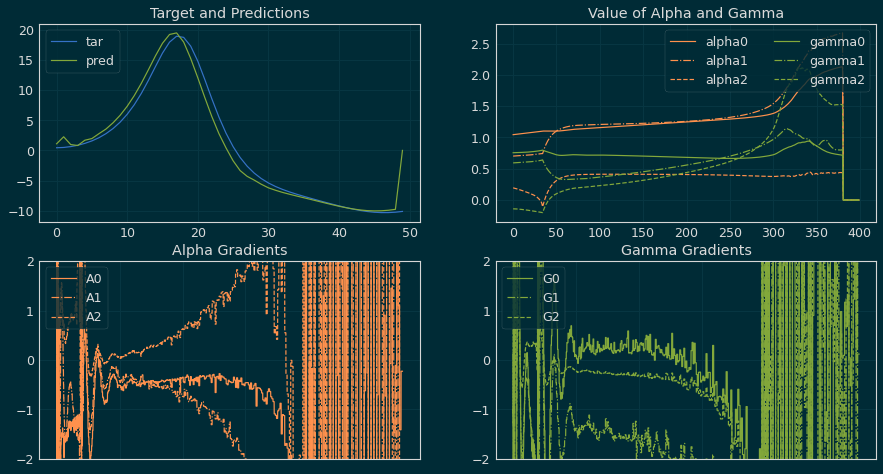

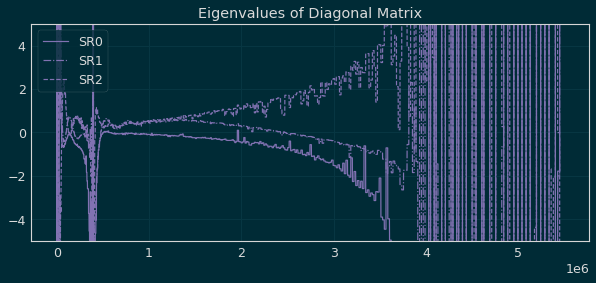

Eigenvals tensor([ 0.6025,  0.1604, -1.4854])
Eigenvals tensor([ 0.6015,  0.1570, -1.4851])
Eigenvals tensor([ 0.6009,  0.1545, -1.4868])
Eigenvals tensor([ 0.5977,  0.1473, -1.4833])
Eigenvals tensor([ 0.5936,  0.1391, -1.4787])
Eigenvals tensor([ 0.5914,  0.1348, -1.4753])
Eigenvals tensor([ 0.5908,  0.1330, -1.4739])
Eigenvals tensor([ 0.5878,  0.1280, -1.4655])
Eigenvals tensor([ 0.5843,  0.1213, -1.4566])
Eigenvals tensor([ 0.5824,  0.1175, -1.4525])
Epoch: 390


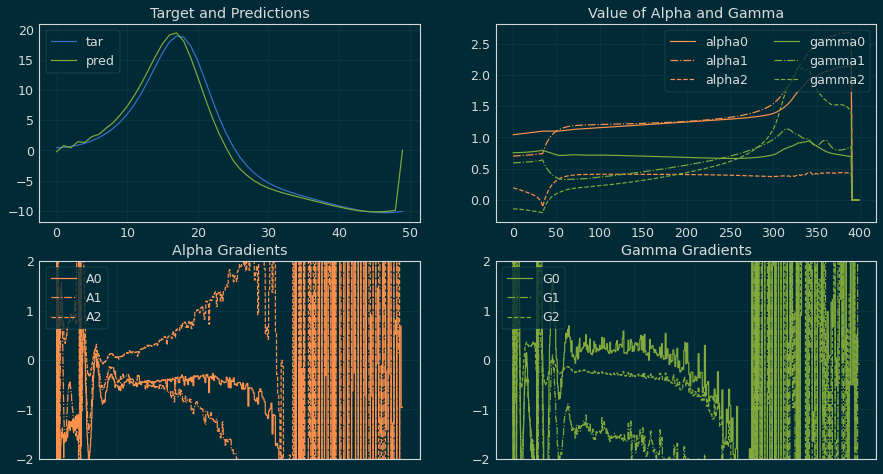

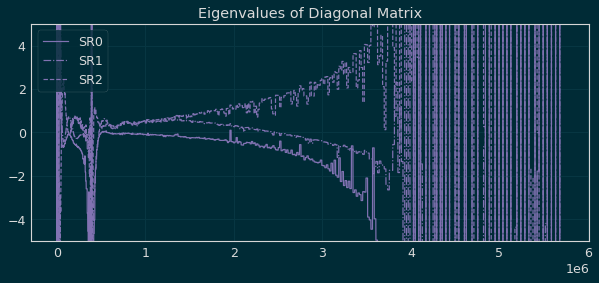

Eigenvals tensor([ 0.5815,  0.1150, -1.4510])
Eigenvals tensor([ 0.5791,  0.1097, -1.4475])
Eigenvals tensor([ 0.5759,  0.1030, -1.4425])
Eigenvals tensor([ 0.5743,  0.0990, -1.4417])
Eigenvals tensor([ 0.5732,  0.0959, -1.4427])
Eigenvals tensor([ 0.5705,  0.0903, -1.4410])
Eigenvals tensor([ 0.5671,  0.0839, -1.4355])
Eigenvals tensor([ 0.5657,  0.0809, -1.4344])
Eigenvals tensor([ 0.5646,  0.0784, -1.4344])


In [11]:
EPOCHS = 400
alphas = np.zeros((EPOCHS,3))
gammas = np.zeros((EPOCHS,3))
eigs = np.zeros((EPOCHS,3))
for ep in range(400):
    preds = np.zeros(TRAIN)
    xt = esn.packState()
    loss = 0.
    optimizer.zero_grad()
    for i in range(Tl-1):
        ut = torch.Tensor([[signal[i]]])
        y = torch.Tensor([[signal[i+1]]])
        xt1, yhat = esn(xt,ut)
        loss += criterion(yhat,y)
        preds[i] = yhat.detach().numpy()[0,0]
        xt = xt1
    loss.backward()
    eigs[ep] = esn.D.data[:]
    alphas[ep] = esn.Lky.a.data[:]
    gammas[ep] = esn.Lky.g.data[:]
    Agrad = np.array([np.squeeze(l.detach().numpy()) for l in  esn.Lky.a_list])
    Ggrad = np.array([np.squeeze(l.detach().numpy()) for l in  esn.Lky.g_list])
    SRgrad = np.array([np.squeeze(l.detach().numpy()) for l in  esn.sr_list])
    print(f'Eigenvals {esn.D.data}')
    optimizer.step()
    esn.clearList()
   
    if(ep%10==0):
        print(f'Epoch: {ep}')
        target = signal[:Tl]
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(221)
        ax1.set_title('Target and Predictions')
        ax1.plot(target, label='tar')
        ax1.plot(preds, label='pred')
        ax1.legend(loc='upper left')

        ax2 = plt.subplot(222)
        ax2.set_title('Value of Alpha and Gamma')
        ax2.plot(alphas[:,0],'y-', label='alpha0')
        ax2.plot(alphas[:,1],'y', linestyle='dashdot', label='alpha1')
        ax2.plot(alphas[:,2],'y--',marker='x', label='alpha2')
        ax2.plot(gammas[:,0],'g-', label='gamma0')
        ax2.plot(gammas[:,1],'g', linestyle='dashdot', label='gamma1')
        ax2.plot(gammas[:,2],'g--',marker='x', label='gamma2')
        ax2.legend(loc='upper right',ncol=2)

        ax3 = plt.subplot(223)
        ax3.set_title('Alpha Gradients')
        ax3.plot(Agrad[:,0],'y-', label='A0')
        ax3.plot(Agrad[:,1],'y', linestyle='dashdot', label='A1')
        ax3.plot(Agrad[:,2],'y--', marker='x', label='A2')
        ax3.set_xticklabels([])
        ax3.set_ylim(-2,2)
        ax3.legend(loc='upper left')
        
        ax4 = plt.subplot(224)
        ax4.set_title('Gamma Gradients')
        ax4.plot(Ggrad[:,0],'g-', label='G0')
        ax4.plot(Ggrad[:,1],'g', linestyle='dashdot', label='G1')
        ax4.plot(Ggrad[:,2],'g--', marker='x', label='G2')
        ax4.set_xticklabels([])
        ax4.set_ylim(-2,2)
        ax4.legend(loc='upper left')
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,4))
        plt.title('Eigenvalues of Diagonal Matrix')
        plt.plot(SRgrad[:,0],'m-', label='SR0')
        plt.plot(SRgrad[:,1],'m', linestyle='dashdot', label='SR1')
        plt.plot(SRgrad[:,2],'m--', marker='x', label='SR2')
        plt.ylim(-5,5)
        plt.legend(loc='upper left')
        plt.show()
        plt.close()
        